In [1]:
''' 
Script para descargar un archivo de Google Drive y mostrar las primeras 10 líneas
'''

url_view = "https://drive.google.com/file/d/1RMKdCJKS7vFBhiTLosCotau1k4UsN5iu/view?usp=sharing"   # Enlace de Google Drive
file_id = url_view.split('/')[5]  # Extrae el ID del archivo (la 6ª parte del enlace)
download_url = f"https://drive.google.com/uc?id={file_id}"   # Crea el enlace de descarga directa

import requests
response = requests.get(download_url)

# Muestra las primeras 10 líneas, para saber el tipo de separación del csv
for i, line in enumerate(response.text.splitlines()[:10], start=1):
    print(f"{i:02d}: {line}")


01: Date;Year;Type;Country;State;Location;Activity;Name;Sex;Age;Injury;Fatal Y/N;Time;Species ;Source;pdf;href formula;href;Case Number;Case Number;original order;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
02: 11th October;2025;Unprovoked;Australia;Queensland;Cook Esplanade Thursday Island;Fishing/swimming;Samuel Nai;M;14;Serious abdonminal injuries;N;1823 hrs;Tiger or Bull shark;Kevin McMurray Trackingsharks.com;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
03: 7th October;2025;Unprovoked;Australia;South Australia;Kangaroo Island;Surfing;Lee Berryman;M;50+;Lacerations to calf ;N;1330hrs;Bronze whaler?;Kevin

In [2]:
import pandas as pd
from typing import Optional #for type hinting purposes 

shark_df = pd.read_csv(download_url, sep=';', encoding='utf-8', low_memory=False)
print("Inicialmente los datos tienen:", shark_df.shape)
print(shark_df.head())  # Muestra las primeras filas del DataFrame

shark_df = shark_df.dropna(axis=1, how='all') # Eliminar columnas vacías enteras
print("Ahora los datos tienen:",shark_df.shape)
print(shark_df.columns)  # Muestra las columnas del DataFrame: 255 col a 23 col

Inicialmente los datos tienen: (39139, 255)
             Date  Year        Type     Country            State  \
0    11th October  2025  Unprovoked   Australia       Queensland   
1     7th October  2025  Unprovoked   Australia  South Australia   
2  29th September  2025  Unprovoked         USA   Off California   
3  27th September  2025    Provoked  Costa Rica              NaN   
4   6th September  2025  Unprovoked   Australia              NSW   

                         Location               Activity                Name  \
0  Cook Esplanade Thursday Island       Fishing/swimming          Samuel Nai   
1                 Kangaroo Island                Surfing        Lee Berryman   
2                 Catalina Island               Swimming  Christopher Murray   
3                   Cocos Islands  Diving-Tagging sharks  Dr. Mauricio Hoyos   
4                Long Reef Sydney                Surfing  Mercury Psillaskis   

  Sex  Age  ... Unnamed: 245 Unnamed: 246 Unnamed: 247 Unnamed: 24

In [3]:
#Quitamos las columnas que no nos sirven para el análisis

shark_df.drop(['Date','Location','Name','Age','Injury','Time','Source', 'pdf', 'href formula', 'href', 'Case Number', 'Case Number.1',
       'original order', 'Unnamed: 21', 'Unnamed: 22'], axis=1, inplace=True)

print(shark_df.columns)  # Muestra las columnas del DF después de eliminar las que no analizaremos

Index(['Year', 'Type', 'Country', 'State', 'Activity', 'Sex', 'Fatal Y/N',
       'Species '],
      dtype='object')


In [4]:
import importlib, Functions
importlib.reload(Functions)
from Functions import standardize_text

In [5]:
shark_df = standardize_text(shark_df)
print(shark_df.head())  # Muestra las primeras filas del DataFrame después de la normalización del texto y las columnas

   year        type     country            state               activity sex  \
0  2025  unprovoked   australia       queensland       fishing/swimming   m   
1  2025  unprovoked   australia  south australia                surfing   m   
2  2025  unprovoked         usa   off california               swimming   m   
3  2025    provoked  costa rica             <NA>  diving-tagging sharks   m   
4  2025  unprovoked   australia              nsw                surfing   m   

  fatal_y/n              species  
0         n  tiger or bull shark  
1         n       bronze whaler?  
2         n   unknown 1.2m shark  
3         n       tiger shark 4m  
4         y    great white shark  


In [6]:
#Check valores únicos por columna:

for col in shark_df.columns:
    print(f'{col.upper()} --> valores únicos:', shark_df[col].unique())

YEAR --> valores únicos: <StringArray>
['2025', '2024', '2026', '2023', '2022', '2021', '2020', '2019', '2018',
 '2017',
 ...
 '1580', '1555', '1554', '1543', '1518', '1500', '1000', '0077', '0005',
 '0000']
Length: 263, dtype: string
TYPE --> valores únicos: <StringArray>
[         'unprovoked',            'provoked',        'questionable',
          'watercraft',        'sea disaster',                  <NA>,
                   '?',         'unconfirmed',          'unverified',
             'invalid', 'under investigation',                'boat']
Length: 12, dtype: string
COUNTRY --> valores únicos: <StringArray>
[               'australia',                      'usa',
               'costa rica',                  'bahamas',
              'puerto rico',         'french polynesia',
                    'spain',           'canary islands',
             'south africa',                  'vanuatu',
 ...
        'mediterranean sea',                   'sweden',
                   'roatan', 'b

In [7]:
shark_df.dtypes

year         string[python]
type         string[python]
country      string[python]
state        string[python]
activity     string[python]
sex          string[python]
fatal_y/n    string[python]
species      string[python]
dtype: object

In [8]:
print('Los valores iniciales eran:', shark_df['year'].nunique)
print('Los valores iniciales eran:', shark_df['year'].shape)
print('Los valores iniciales eran:', shark_df['type'].nunique)
print('Los valores iniciales eran:', shark_df['type'].shape)

#PRIMER FILTRO (Marlene):

shark_df = shark_df[shark_df['type'] == 'unprovoked'].copy() #Quitamos los accidentes que no sean "unprovoked"
print('Los valores finales son:', shark_df['type'].unique)
print('Los valores finales son:', shark_df['type'].shape)

Los valores iniciales eran: <bound method IndexOpsMixin.nunique of 0        2025
1        2025
2        2025
3        2025
4        2025
         ... 
39134    <NA>
39135    <NA>
39136    <NA>
39137    <NA>
39138    <NA>
Name: year, Length: 39139, dtype: string>
Los valores iniciales eran: (39139,)
Los valores iniciales eran: <bound method IndexOpsMixin.nunique of 0        unprovoked
1        unprovoked
2        unprovoked
3          provoked
4        unprovoked
            ...    
39134          <NA>
39135          <NA>
39136          <NA>
39137          <NA>
39138          <NA>
Name: type, Length: 39139, dtype: string>
Los valores iniciales eran: (39139,)
Los valores finales son: <bound method Series.unique of 0       unprovoked
1       unprovoked
2       unprovoked
4       unprovoked
5       unprovoked
           ...    
7044    unprovoked
7045    unprovoked
7046    unprovoked
7047    unprovoked
7048    unprovoked
Name: type, Length: 5203, dtype: string>
Los valores finales son: (52

In [9]:
print(shark_df[['year']].isnull().sum())

shark_df = shark_df.dropna(subset=['year']) #Quitamos los null de la columna "year"

print(shark_df.isnull().sum())

year    1
dtype: int64
year            0
type            0
country        33
state         300
activity      359
sex           168
fatal_y/n      17
species      2598
dtype: int64


In [10]:
#formateamos para que todos los string sean igual (con decimal ".")

shark_df['year'] = (
    shark_df['year']
    .astype(str)                 
    .str.replace(',', '.', regex=False)  # cambia coma por punto
    .astype(float)      
)
shark_df['year'] = pd.to_numeric(shark_df['year'])
shark_df = shark_df.loc[(shark_df['year'] >= 2000) & (shark_df['year'] <= 2025)] #filtramos los años sujetos a estudio

#convertimos de nuevo a string para evitar problemas en futuros análisis
shark_df['year'] = shark_df['year'].astype(int).astype(str)

#CHECK FILTRO 1
print('Post filtro quedan:', shark_df['year'].shape , "valores")
print('Post filtro quedan:', shark_df['type'].shape , "valores")


Post filtro quedan: (2206,) valores
Post filtro quedan: (2206,) valores


In [11]:
#Check valores por columnas para próximos filtros

for col in shark_df.columns:
    print(f'{col.upper()} --> valores únicos:', shark_df[col].unique())

YEAR --> valores únicos: ['2025' '2024' '2023' '2022' '2021' '2020' '2019' '2018' '2017' '2016'
 '2015' '2014' '2013' '2012' '2011' '2010' '2009' '2008' '2007' '2006'
 '2005' '2004' '2003' '2002' '2001' '2000']
TYPE --> valores únicos: <StringArray>
['unprovoked']
Length: 1, dtype: string
COUNTRY --> valores únicos: <StringArray>
[                            'australia',
                                   'usa',
                               'bahamas',
                           'puerto rico',
                      'french polynesia',
                                 'spain',
                        'canary islands',
                          'south africa',
                               'vanuatu',
                               'jamaica',
                                'israel',
                              'maldives',
                      'turks and caicos',
                            'mozambique',
                         'new caledonia',
                                 'egyp

In [12]:
#SEGUNDO FILTRO (Marta):
#Decidimos filtrar por 11 países que representan el 90% de los ataques. 
country_selected = [
    "usa","australia","south africa","bahamas","brazil","new zealand",
    "new caledonia","egypt","reunion","french polynesia","mexico","reunion island"]

shark_df_filtered = shark_df[
    shark_df["country"].str.strip().str.lower().isin(country_selected)
].copy()

print("Después del segundo filtro, los datos tienen:", shark_df_filtered.shape)
# Reunion y Reunion island los llamamos como Reunion Island

map_reunion = {"reunion island": "reunion"}
shark_df_filtered["country"] = shark_df_filtered["country"].replace(map_reunion)
print(shark_df_filtered["country"].value_counts(dropna=False).sort_index())
shark_df = shark_df_filtered #sobrescribe el dataframe con los filtros y demás


Después del segundo filtro, los datos tienen: (1977, 8)
country
australia            434
bahamas               69
brazil                54
egypt                 30
french polynesia      26
mexico                25
new caledonia         35
new zealand           38
reunion               30
south africa         115
usa                 1121
Name: count, dtype: Int64


In [13]:
# Borramos state en blanco para esos paises
print("Antes:", shark_df_filtered.shape)
shark_df_filtered = shark_df_filtered.dropna(subset=["state"]).copy()
print("Después:", shark_df_filtered.shape)

Antes: (1977, 8)
Después: (1934, 8)


In [14]:
#Normalizando nombres de estados para los países seleccionados
#USA:

mask_usa = shark_df_filtered["country"].eq("usa")

# Diccionario de normalización (todo en minúsculas)
usa_state_map = {
    "floria": "florida",
    "franklin county, florida": "florida",
    "noirth carolina": "north carolina",
    "off california": "california",
    "los angeles": "california",
    "long island ny": "new york",
    "maui": "hawaii",
    "virgin islands": "us virgin islands",
 }

print("Después de normalizar estados USA:", shark_df_filtered.loc[mask_usa, "state"].replace(usa_state_map).value_counts())

Después de normalizar estados USA: state
florida              602
hawaii               152
california           103
south carolina        79
north carolina        69
texas                 34
new york              16
oregon                16
alabama               10
louisiana              6
georgia                5
new jersey             5
massachusetts          4
maine                  2
guam                   2
us virgin islands      2
virginia               2
galveston              1
samoa                  1
maryland               1
cayman islands         1
bahamas                1
washington             1
rhode island           1
delaware               1
palmyra atoll          1
puerto rico            1
johnston atoll         1
Name: count, dtype: Int64


In [15]:
#Australia:

mask_aus = shark_df_filtered["country"].eq("australia")

aus_state_map = {
    "new  south wales": "new south wales",
    "new south ales": "new south wales",
    "nsw": "new south wales",
    "wa": "western australia",
    "westerm australia": "western australia",
    "western  australia": "western australia",
}

print(
    "Después de normalizar estados AU:",
    shark_df_filtered.loc[mask_aus, "state"]
        .replace(aus_state_map)
        .value_counts()
)

Después de normalizar estados AU: state
new south wales                         164
western australia                       120
queensland                               77
south australia                          36
victoria                                 23
tasmania                                  6
northern territory                        5
torres strait                             1
territory of cocos (keeling) islands      1
Name: count, dtype: Int64


In [16]:
#South Africa:
mask_sa = shark_df_filtered["country"].eq("south africa")

sa_state_map = {
    "easten cape province": "eastern cape",
    "eastern cape  province": "eastern cape",
    "eastern cape province": "eastern cape",
    "eastern province": "eastern cape", 
    "kwazulu-natal between port edward and port st johns": "kwazulu-natal",
    "western cape province": "western cape",
    "western province": "western cape",
}

print(
    "Después de normalizar estados South Africa:",
    shark_df_filtered.loc[mask_sa, "state"]
        .replace(sa_state_map)
        .value_counts()
)


Después de normalizar estados South Africa: state
western cape     48
eastern cape     46
kwazulu-natal    19
Name: count, dtype: Int64


In [17]:
#Bahamas:
mask_bhs = shark_df_filtered["country"].eq("bahamas")

bahamas_state_map = {
    # --- Grand Bahama (incluye off-shore y ciudades) ---
    "40 miles off grand bahama island": "grand bahama",
    "grand  bahama island": "grand bahama",
    "grand bahama island": "grand bahama",
    "freeport": "grand bahama",
    "west end": "grand bahama",

    # --- Abaco ---
    "abaco islands": "abaco",
    "great abaco islands": "abaco",
    "atlantic ocean near big grand cay": "abaco",

    # --- Andros ---
    "andros islands": "andros",

    # --- Exuma ---
    "exuma islands": "exuma",
    "exumas": "exuma",
    "the exuma cays": "exuma",

    # --- New Providence (+ Paradise Island y variantes tipográficas) ---
    "new providence   isoad": "new providence",
    "new providence district": "new providence",
    "new providence island": "new providence",
    "paradise island": "new providence",

    # --- Long Island (typo en el dato) ---
    "clarence town long isand": "long island",
}

print(
    "Después de normalizar Bahamas:",
    shark_df_filtered.loc[mask_bhs, "state"]
        .str.strip().str.lower()
        .replace(bahamas_state_map)
        .value_counts()
)

Después de normalizar Bahamas: state
abaco                  22
grand bahama           10
exuma                   7
new providence          7
eleuthera               2
long island             1
lucayan archipelago     1
bimini                  1
northern bahamas        1
andros                  1
Name: count, dtype: Int64


In [18]:
#Brasil:
mask_bra = shark_df_filtered["country"].eq("brazil")

brazil_state_map = {
    "balneário camboriú": "santa catarina",
    "santa catarina state": "santa catarina",
    "rio grande de norte": "rio grande do norte",
    "fernando de noronha": "pernambuco",
    "são paulo.": "sao paulo",
}

print(
    "Después de normalizar Brasil:",
    shark_df_filtered.loc[mask_bra, "state"]
        .str.strip().str.lower()
        .replace(brazil_state_map)
        .value_counts())

Después de normalizar Brasil: state
pernambuco             42
sao paulo               2
santa catarina          2
bahia                   2
rio de janeiro          2
rio grande do sul       1
rio grande do norte     1
Name: count, dtype: Int64


In [19]:
#New Zealand:
mask_nz = shark_df_filtered["country"].eq("new zealand")

nz_state_map = {
    "south island, near karitane north of dunedin": "south island",
    "southland": "south island",
    "bay of waitangi": "north island",
    "mercury islands": "north island",
  }

print(
    "Después de normalizar New Zealand:",
    shark_df_filtered.loc[mask_nz, "state"]
        .str.strip().str.lower()
        .replace(nz_state_map)
        .value_counts()
)

Después de normalizar New Zealand: state
south island       18
north island       16
cook islands        3
chatham islands     1
Name: count, dtype: Int64


In [20]:
#New Caledonia:

mask_nc = shark_df_filtered["country"].eq("new caledonia")

nc_state_map = {
    "bélep islands": "belep islands",
    "grande terre": "grand terre",
}

print(
    "Después de normalizar New Caledonia:",
    shark_df_filtered.loc[mask_nc, "state"]
        .str.strip().str.lower()
        .replace(nc_state_map)
        .value_counts()
)


Después de normalizar New Caledonia: state
south province          8
north province          8
loyalty islands         5
grand terre             2
poum                    1
belep islands           1
noumea                  1
baie de sainte-marie    1
Name: count, dtype: Int64


In [21]:
#Egipto:
mask_egy = shark_df_filtered["country"].eq("egypt")

egypt_state_map = {
    "hurghada, red sea governorate": "red sea governorate",
    "north of marsa alam": "red sea governorate",
    "red sea": "red sea governorate",
    "red sea protectorate": "red sea governorate",
    "st. johns reef": "red sea governorate",
    "sinai peninsula": "south sinai",
    "south sinai peninsula": "south sinai",
}

print(
    "Después de normalizar Egipto:",
    shark_df_filtered.loc[mask_egy, "state"]
        .str.strip().str.lower()
        .replace(egypt_state_map)
        .value_counts()
)


Después de normalizar Egipto: state
red sea governorate    12
south sinai            12
suez                    1
Name: count, dtype: Int64


In [22]:
#Reunion:

mask_reu = shark_df_filtered["country"].eq("reunion")

s = (
    shark_df_filtered.loc[mask_reu, "state"]
        .astype("string")
        .str.strip().str.lower()
        .str.replace("-", " ", regex=False)         # "saint-gilles" -> "saint gilles"
        .replace({
            "saint guilles": "saint gilles",        # typo
            "saint gilles les bains": "saint gilles",
            "d'etang-sale": "etang sale",
            "d’etang-sale": "etang sale",
            "d'etang-salé": "etang sale",
            "d’etang-salé": "etang sale",
            "conservatória district": "conservatoria district",
        })
)

# Agrupa TODO lo que empiece por "saint " en "saint areas"
s = s.where(~s.str.startswith("saint "), "saint areas")

print("Después de normalizar Reunion:")
print(s.value_counts())

Después de normalizar Reunion:
state
saint areas               17
d’étang salé               2
le port                    1
trois bassins              1
bois blanc                 1
conservatoria district     1
Name: count, dtype: Int64


In [23]:
# French Polynesia
mask_fp = shark_df_filtered["country"].eq("french polynesia")

french_poly_map = {
    # Society Islands
    "bora bora": "society islands",
    "moorea": "society islands",
    "tahiti": "society islands",
    "nuku hiva": "marquesas",
    "central tuamotu": "tuamotu islands",
    "tuamotos": "tuamotu islands",
    "tuamotus": "tuamotu islands",
    "rangiroa": "tuamotu islands",
}

print(
    "Después de normalizar French Polynesia:",
    shark_df_filtered.loc[mask_fp, "state"]
        .str.strip().str.lower()
        .replace(french_poly_map)
        .value_counts()
)

Después de normalizar French Polynesia: state
society islands    14
tuamotu islands     6
marquesas           4
gambier islands     1
Name: count, dtype: Int64


In [24]:
#Mexico:
mask_mex = shark_df_filtered["country"].eq("mexico")

mexico_state_map = {
    "guerrero": "guerrero",
    "cabo san lucas": "baja california",
    "baja": "baja california",
    "baja california sur": "baja california",
    "guerro": "guerrero",
}

print(
    "Después de normalizar Méxipwdco:",
    shark_df_filtered.loc[mask_mex, "state"]
        .str.strip().str.lower()
        .replace(mexico_state_map)
        .value_counts()
)

Después de normalizar Méxipwdco: state
quintana roo          7
baja california       6
guerrero              6
sonora                3
jalisco               1
gulf of california    1
sinaloa               1
Name: count, dtype: Int64


In [25]:
#Asignamos los cambios al dataframe principal
# Use shark_df_filtered since the masks were created from it
shark_df_filtered.loc[mask_usa, "state"] = shark_df_filtered.loc[mask_usa, "state"].replace(usa_state_map)
shark_df_filtered.loc[mask_aus, "state"] = shark_df_filtered.loc[mask_aus, "state"].replace(aus_state_map)
shark_df_filtered.loc[mask_sa, "state"] = shark_df_filtered.loc[mask_sa, "state"].replace(sa_state_map)
shark_df_filtered.loc[mask_bhs, "state"] = shark_df_filtered.loc[mask_bhs, "state"].replace(bahamas_state_map)
shark_df_filtered.loc[mask_bra, "state"] = shark_df_filtered.loc[mask_bra, "state"].replace(brazil_state_map)
shark_df_filtered.loc[mask_nz, "state"] = shark_df_filtered.loc[mask_nz, "state"].replace(nz_state_map)
shark_df_filtered.loc[mask_nc, "state"] = shark_df_filtered.loc[mask_nc, "state"].replace(nc_state_map)
shark_df_filtered.loc[mask_egy, "state"] = shark_df_filtered.loc[mask_egy, "state"].replace(egypt_state_map)
shark_df_filtered.loc[mask_reu, "state"] = s
shark_df_filtered.loc[mask_fp, "state"] = shark_df_filtered.loc[mask_fp, "state"].replace(french_poly_map)
shark_df_filtered.loc[mask_mex, "state"] = shark_df_filtered.loc[mask_mex, "state"].replace(mexico_state_map)
shark_df

# Update shark_df to the cleaned version
shark_df = shark_df_filtered


In [26]:
# TERCER FILTRO (Alejandro):
# Valoramos los duplicados de las actividades que estaban realizando los atacados, para agruparlas en categorias iguales.
shark_df['activity'].value_counts()

activity
surfing                                             722
swimming                                            318
spearfishing                                        113
snorkeling                                           87
wading                                               86
                                                   ... 
swimming out to porpoises                             1
windsurfing, but sitting on his board                 1
surfing / wading                                      1
spearfishing, holding mesh bag with speared fish      1
boogie boarding / wading                              1
Name: count, Length: 187, dtype: Int64

In [27]:
# Agrupamos las actividades en sus categorias
# Diving
mask_diving = shark_df_filtered["activity"].str.strip().str.lower().isin([
    "abalone diving",
    "diving",
    "diving (shell maintenance)",
    "diving / filming",
    "diving for abalone",
    "diving for crayfish",
    "diving into water",
    "diving with  surface-supplied air",
    "diving, but on the surface when bitten by the shark",
    "free diving",
    "free diving / modeling",
    "free diving / photographing pilot whales",
    "free diving / spearfishing",
    "freediving",
    "scuba diving",
    "snorkeling",
    "snorkeling (filming the sardine run)",
    "standing / snorkeling"
])

activity_diving_map = {
    "abalone diving": "diving",
    "diving": "diving",
    "diving (shell maintenance)": "diving",
    "diving / filming": "diving",
    "diving for abalone": "diving",
    "diving for crayfish": "diving",
    "diving into water": "diving",
    "diving with  surface-supplied air": "diving",
    "diving, but on the surface when bitten by the shark": "diving",
    "free diving": "diving",
    "free diving / modeling": "diving",
    "free diving / photographing pilot whales": "diving",
    "free diving / spearfishing": "diving",
    "freediving": "diving",
    "scuba diving": "diving",
    "snorkeling": "diving",
    "snorkeling (filming the sardine run)": "diving",
    "standing / snorkeling": "diving",
}

print(
    "Después de normalizar 'activity' → 'diving':",
    shark_df_filtered.loc[mask_diving, "activity"]
        .str.strip().str.lower()
        .replace(activity_diving_map)
        .value_counts()
)

shark_df_filtered.loc[mask_diving, "activity"] = (
    shark_df_filtered.loc[mask_diving, "activity"]
        .str.strip().str.lower()
        .replace(activity_diving_map)
)

Después de normalizar 'activity' → 'diving': activity
diving    171
Name: count, dtype: Int64


In [28]:
# Swimming
mask_swimming = shark_df_filtered["activity"].str.strip().str.lower().isin([
    "bathing",
    "batin",
    "crouching in 2' of water",
    "floating",
    "floating face-down in knee-deep water",
    "floating in inflatable pool ring",
    "floating in tube",
    "floating near boat & observing bioluminesce",
    "floating on a raft",
    "holding onto an inflatable boat",
    "in water with diving seabirds",
    "jumped into the water",
    "jumped into water",
    "jumpinf from dock to boat acidentally fell into water at marina",
    "jumping",
    "jumping in the waves",
    "kneeling in the water",
    "lifeguard exercises",
    "lifeguard training exercise",
    "lifesaving drill",
    "playing",
    "playing football in the water",
    "playing in the surf",
    "playing in the surf with his 2 dogs",
    "playing in the water",
    "playing on a sandbar",
    "playing soccer in the water",
    "squatting in the water",
    "standing",
    "swimming",
    "swimming  or snorkeling",
    "swimming & snorkeling",
    "swimming (using a float)",
    "swimming /  boogie boarding",
    "swimming / body surfing",
    "swimming / jumping off a jetty",
    "swimming / shipwreck",
    "swimming / snorkeling",
    "swimming / treading water",
    "swimming / wading",
    "swimming ocean training",
    "swimming or boogie boarding",
    "swimming out to porpoises",
    "swimming to shore from capsized kayak",
    "swimming with boogie board",
    "swimming with pod of dolphins",
    "swimming with sharks",
    "swimming, attempting to rescue a girl  believed to be drowning",
    "swimming, poaching abalone",
    "swimming, poaching perlemoen",
    "swimming, towing surfboard",
    "swimming, wearing black wetsuit & swim fins",
    "swimming/ treading water",
    "swimming/standing",
    "swimmingq",
    "treading water",
    "treading water/ surfing",
    "unconfirmed possibly swimming near the boat harbour",
    "undisclosed",
    "wade fishing",
    "wade-fishing",
    "wading",
    "wading / fishing & carrying a bag of fish",
    "wading near a fishing net",
    "wading or swimming",
    "wading?"
])

activity_swimming_map = {
    "bathing": "swimming",
    "batin": "swimming",
    "crouching in 2' of water": "swimming",
    "floating": "swimming",
    "floating face-down in knee-deep water": "swimming",
    "floating in inflatable pool ring": "swimming",
    "floating in tube": "swimming",
    "floating near boat & observing bioluminesce": "swimming",
    "floating on a raft": "swimming",
    "holding onto an inflatable boat": "swimming",
    "in water with diving seabirds": "swimming",
    "jumped into the water": "swimming",
    "jumped into water": "swimming",
    "jumpinf from dock to boat acidentally fell into water at marina": "swimming",
    "jumping": "swimming",
    "jumping in the waves": "swimming",
    "kneeling in the water": "swimming",
    "lifeguard exercises": "swimming",
    "lifeguard training exercise": "swimming",
    "lifesaving drill": "swimming",
    "playing": "swimming",
    "playing football in the water": "swimming",
    "playing in the surf": "swimming",
    "playing in the surf with his 2 dogs": "swimming",
    "playing in the water": "swimming",
    "playing on a sandbar": "swimming",
    "playing soccer in the water": "swimming",
    "squatting in the water": "swimming",
    "standing": "swimming",
    "swimming": "swimming",
    "swimming  or snorkeling": "swimming",
    "swimming & snorkeling": "swimming",
    "swimming (using a float)": "swimming",
    "swimming /  boogie boarding": "swimming",
    "swimming / body surfing": "swimming",
    "swimming / jumping off a jetty": "swimming",
    "swimming / shipwreck": "swimming",
    "swimming / snorkeling": "swimming",
    "swimming / treading water": "swimming",
    "swimming / wading": "swimming",
    "swimming ocean training": "swimming",
    "swimming or boogie boarding": "swimming",
    "swimming out to porpoises": "swimming",
    "swimming to shore from capsized kayak": "swimming",
    "swimming with boogie board": "swimming",
    "swimming with pod of dolphins": "swimming",
    "swimming with sharks": "swimming",
    "swimming, attempting to rescue a girl  believed to be drowning": "swimming",
    "swimming, poaching abalone": "swimming",
    "swimming, poaching perlemoen": "swimming",
    "swimming, towing surfboard": "swimming",
    "swimming, wearing black wetsuit & swim fins": "swimming",
    "swimming/ treading water": "swimming",
    "swimming/standing": "swimming",
    "swimmingq": "swimming",
    "treading water": "swimming",
    "treading water/ surfing": "swimming",
    "unconfirmed possibly swimming near the boat harbour": "swimming",
    "undisclosed": "swimming",
    "wade fishing": "swimming",
    "wade-fishing": "swimming",
    "wading": "swimming",
    "wading / fishing & carrying a bag of fish": "swimming",
    "wading near a fishing net": "swimming",
    "wading or swimming": "swimming",
    "wading?": "swimming",
}

print(
    "Después de normalizar 'activity' → 'swimming':",
    shark_df_filtered.loc[mask_swimming, "activity"]
        .str.strip().str.lower()
        .replace(activity_swimming_map)
        .value_counts()
)

shark_df_filtered.loc[mask_swimming, "activity"] = (
    shark_df_filtered.loc[mask_swimming, "activity"]
        .str.strip().str.lower()
        .replace(activity_swimming_map)
)

Después de normalizar 'activity' → 'swimming': activity
swimming    541
Name: count, dtype: Int64


In [29]:
# Study
mask_study = shark_df_filtered["activity"].str.strip().str.lower().isin([
    "attempting to rescue a shark",
    "photographing fish",
    "photographing the shark",
    "tagging sharks",
    "wrangling a shark",
])

activity_study_map = {
    "attempting to rescue a shark": "study",
    "photographing fish": "study",
    "photographing the shark": "study",
    "tagging sharks": "study",
    "wrangling a shark": "study",
}

print(
    "Después de normalizar 'activity':",
    shark_df_filtered.loc[mask_study, "activity"]
        .str.strip().str.lower()
        .replace(activity_study_map)
        .value_counts()
)

shark_df_filtered.loc[mask_study, "activity"] = (
    shark_df_filtered.loc[mask_study, "activity"]
        .str.strip().str.lower()
        .replace(activity_study_map)
)

Después de normalizar 'activity': activity
study    5
Name: count, dtype: Int64


In [30]:
# Paddle

mask_paddle = shark_df_filtered["activity"].str.strip().str.lower().isin([
    "body boarding",
    "body surfing",
    "body surfing or boogie boarding",
    "body surfing?",
    "bodyboarding",
    "body-boarding",
    "bodysurfing",
    "body-surfing",
    "boggie boarding",
    "boogie boarding",
    "boogie boarding / wading",
    "boogie boarding or surfing",
    "boogie-boarding / swimming",
    "paddle boarding",
    "paddleboarding",
    "paddle-boarding",
    "paddle-surfing",
    "paddling on kneeboard",
    "standing alongside surfboard",
    "standing in inner tube",
    "standing or boogie boardin",
    "standing, stepped on shark",
    "stand-up paddle boarding",
    "stand-up paddleboarding",
    "sup",
    "sup foil boarding"
])

activity_paddle_map = {
    "body boarding": "paddle",
    "body surfing": "paddle",
    "body surfing or boogie boarding": "paddle",
    "body surfing?": "paddle",
    "bodyboarding": "paddle",
    "body-boarding": "paddle",
    "bodysurfing": "paddle",
    "body-surfing": "paddle",
    "boggie boarding": "paddle",
    "boogie boarding": "paddle",
    "boogie boarding / wading": "paddle",
    "boogie boarding or surfing": "paddle",
    "boogie-boarding / swimming": "paddle",
    "paddle boarding": "paddle",
    "paddleboarding": "paddle",
    "paddle-boarding": "paddle",
    "paddle-surfing": "paddle",
    "paddling on kneeboard": "paddle",
    "standing alongside surfboard": "paddle",
    "standing in inner tube": "paddle",
    "standing or boogie boardin": "paddle",
    "standing, stepped on shark": "paddle",
    "stand-up paddle boarding": "paddle",
    "stand-up paddleboarding": "paddle",
    "sup": "paddle",
    "sup foil boarding": "paddle",
}

print(
    "Después de normalizar 'activity' → 'paddle':",
    shark_df_filtered.loc[mask_paddle, "activity"]
        .str.strip().str.lower()
        .replace(activity_paddle_map)
        .value_counts()
)

shark_df_filtered.loc[mask_paddle, "activity"] = (
    shark_df_filtered.loc[mask_paddle, "activity"]
        .str.strip().str.lower()
        .replace(activity_paddle_map)
)

Después de normalizar 'activity' → 'paddle': activity
paddle    151
Name: count, dtype: Int64


In [31]:
# Fishing
mask_fishing = shark_df_filtered["activity"].str.strip().str.lower().isin([
    "casting a net",
    "chumming for white sharks",
    "cleaning fish",
    "feeding fish",
    "feeding sharks",
    "fell into the water",
    "fihing",
    "filming",
    "fishing",
    "fishing from surfboard",
    "fishing from surfski",
    "fishing, fell in water",
    "fishing, standing in 2' of water",
    "fishing/swimming",
    "fly fishing",
    "hand feeding sharks",
    "lobstering",
    "removing fish from a trap",
    "scallop diving (using surface-supplied air & a pod)",
    "scallop diving on hookah",
    "scalloping",
    "spearfishing",
    "spearfishing (free diving)",
    "spearfishing / diving",
    "spearfishing / free diving",
    "spearfishing, holding mesh bag with speared fish",
    "washing hands",
    "washing sand off a speared fish",
])

activity_fishing_map = {
    "casting a net": "fishing",
    "chumming for white sharks": "fishing",
    "cleaning fish": "fishing",
    "feeding fish": "fishing",
    "feeding sharks": "fishing",
    "fell into the water": "fishing",
    "fihing": "fishing",
    "filming": "fishing",
    "fishing": "fishing",
    "fishing from surfboard": "fishing",
    "fishing from surfski": "fishing",
    "fishing, fell in water": "fishing",
    "fishing, standing in 2' of water": "fishing",
    "fishing/swimming": "fishing",
    "fly fishing": "fishing",
    "hand feeding sharks": "fishing",
    "lobstering": "fishing",
    "removing fish from a trap": "fishing",
    "scallop diving (using surface-supplied air & a pod)": "fishing",
    "scallop diving on hookah": "fishing",
    "scalloping": "fishing",
    "spearfishing": "fishing",
    "spearfishing (free diving)": "fishing",
    "spearfishing / diving": "fishing",
    "spearfishing / free diving": "fishing",
    "spearfishing, holding mesh bag with speared fish": "fishing",
    "washing hands": "fishing",
    "washing sand off a speared fish": "fishing",
}

print(
    "Después de normalizar 'activity' → 'fishing':",
    shark_df_filtered.loc[mask_fishing, "activity"]
        .str.strip().str.lower()
        .replace(activity_fishing_map)
        .value_counts()
)

shark_df_filtered.loc[mask_fishing, "activity"] = (
    shark_df_filtered.loc[mask_fishing, "activity"]
        .str.strip().str.lower()
        .replace(activity_fishing_map)
)

Después de normalizar 'activity' → 'fishing': activity
fishing    170
Name: count, dtype: Int64


In [32]:
# Surfing
mask_surfing = shark_df_filtered["activity"].str.strip().str.lower().isin([
    "foil boarding",
    "foil-boarding",
    "jet skiing",
    "kite boarding",
    "kite foiling",
    "kite surfing",
    "kiteboarding",
    "kite-boarding",
    "kitesurfing",
    "kite-surfing",
    "night surfing",
    "scurfing (surfboard being  towed behind a boat)",
    "sitting",
    "sitting in the water",
    "sitting on surfboard",
    "skimboarding",
    "standing / surfing",
    "surf fishing",
    "surf paddling",
    "surf skiing",
    "surface supplied  diving",
    "surfing",
    "surfing / wading",
    "surfing amid a shoal of sharks",
    "surfing, but standing in water alongside board",
    "surfng",
    "surf-skiing",
    "surf-sking",
    "tandem surfing",
    "wakeboarding",
    "walking",
    "walking in shallows",
    "walking in surf",
    "walking out of the water after surfing",
    "windsurfing",
    "windsurfing, but sitting on his board",
    "wing foil surfing"
])

activity_surfing_map = {
    "foil boarding": "surfing",
    "foil-boarding": "surfing",
    "jet skiing": "surfing",
    "kite boarding": "surfing",
    "kite foiling": "surfing",
    "kite surfing": "surfing",
    "kiteboarding": "surfing",
    "kite-boarding": "surfing",
    "kitesurfing": "surfing",
    "kite-surfing": "surfing",
    "night surfing": "surfing",
    "scurfing (surfboard being  towed behind a boat)": "surfing",
    "sitting": "surfing",
    "sitting in the water": "surfing",
    "sitting on surfboard": "surfing",
    "skimboarding": "surfing",
    "standing / surfing": "surfing",
    "surf fishing": "surfing",
    "surf paddling": "surfing",
    "surf skiing": "surfing",
    "surface supplied  diving": "surfing",
    "surfing": "surfing",
    "surfing / wading": "surfing",
    "surfing amid a shoal of sharks": "surfing",
    "surfing, but standing in water alongside board": "surfing",
    "surfng": "surfing",
    "surf-skiing": "surfing",
    "surf-sking": "surfing",
    "tandem surfing": "surfing",
    "wakeboarding": "surfing",
    "walking": "surfing",
    "walking in shallows": "surfing",
    "walking in surf": "surfing",
    "walking out of the water after surfing": "surfing",
    "windsurfing": "surfing",
    "windsurfing, but sitting on his board": "surfing",
    "wing foil surfing": "surfing",
}

print(
    "Después de normalizar 'activity' → 'surfing':",
    shark_df_filtered.loc[mask_surfing, "activity"]
        .str.strip().str.lower()
        .replace(activity_surfing_map)
        .value_counts()
)

shark_df_filtered.loc[mask_surfing, "activity"] = (
    shark_df_filtered.loc[mask_surfing, "activity"]
        .str.strip().str.lower()
        .replace(activity_surfing_map)
)

Después de normalizar 'activity' → 'surfing': activity
surfing    814
Name: count, dtype: Int64


In [33]:
# Kayaking
mask_kayaking = shark_df_filtered["activity"].str.strip().str.lower().isin([
    "canoeing",
    "kakaying",
    "kayak fishing",
    "kayaking",
    "kayaking / fishing"
])

activity_kayaking_map = {
    "canoeing": "kayaking",
    "kakaying": "kayaking",
    "kayak fishing": "kayaking",
    "kayaking": "kayaking",
    "kayaking / fishing": "kayaking",
}

print(
    "Después de normalizar 'activity' → 'kayaking':",
    shark_df_filtered.loc[mask_kayaking, "activity"]
        .str.strip().str.lower()
        .replace(activity_kayaking_map)
        .value_counts()
)

shark_df_filtered.loc[mask_kayaking, "activity"] = (
    shark_df_filtered.loc[mask_kayaking, "activity"]
        .str.strip().str.lower()
        .replace(activity_kayaking_map)
)

Después de normalizar 'activity' → 'kayaking': activity
kayaking    14
Name: count, dtype: Int64


In [34]:
# Hacemos un checkeo, para saber el numero de ataques dependiendo de la actividad.
shark_df["activity"].value_counts().head(10)

activity
surfing                    814
swimming                   541
diving                     171
fishing                    170
paddle                     151
kayaking                    14
study                        5
shipwreck                    1
attempting to fix motor      1
Name: count, dtype: Int64

In [35]:
# Valoramos los NaN de las categorias "activity" y "sex" para agruparlas en unkwnown
shark_df[["activity", "sex"]].isna().sum()

activity    66
sex         30
dtype: int64

In [36]:
import numpy as np

In [37]:
shark_df["activity"] = shark_df["activity"].replace("", np.nan)  # convierte strings vacíos en NaN
shark_df["activity"] = shark_df["activity"].fillna("unknown activity") #completa los NULL con "unknown"

In [38]:
shark_df["sex"] = shark_df["sex"].replace("", np.nan)  # convierte strings vacíos en NaN
shark_df["sex"] = shark_df["sex"].fillna("unknown sex") #completa los NULL con "unknown"

#replace de "lli" por "unknown" en la columna "sex"
shark_df["sex"] = shark_df["sex"].replace("lli", "unknown sex")

In [39]:
# Chekeamos los cambios.
shark_df[["activity", "sex"]].isna().sum()

activity    0
sex         0
dtype: int64

In [40]:
#Check valores por columnas para próximos filtros

for col in shark_df.columns:
    print(f'{col.upper()} --> valores únicos:', shark_df[col].unique())

YEAR --> valores únicos: ['2025' '2024' '2023' '2022' '2021' '2020' '2019' '2018' '2017' '2016'
 '2015' '2014' '2013' '2012' '2011' '2010' '2009' '2008' '2007' '2006'
 '2005' '2004' '2003' '2002' '2001' '2000']
TYPE --> valores únicos: <StringArray>
['unprovoked']
Length: 1, dtype: string
COUNTRY --> valores únicos: <StringArray>
[       'australia',              'usa',          'bahamas',
 'french polynesia',     'south africa',    'new caledonia',
            'egypt',      'new zealand',           'mexico',
           'brazil',          'reunion']
Length: 11, dtype: string
STATE --> valores únicos: <StringArray>
[                          'queensland',
                      'south australia',
                           'california',
                      'new south wales',
                              'florida',
                                'texas',
                                'abaco',
                            'marquesas',
                        'kwazulu-natal',
         

In [41]:
# CUARTO FILTRO (CLAUDIA):
# Valoramos los duplicados de las actividades que estaban realizando los atacados, para agruparlas en categorias iguales.
shark_df['fatal_y/n'].value_counts()

fatal_y/n
n          1749
y           171
f             2
unknown       2
nq            1
Name: count, dtype: Int64

In [42]:
# Definimos el mapeo de reemplazo
fatal_map = {
    "f": "unknown",
    "nq": "n",
    "unknown": "unknown",
    "": "unknown",   # celdas vacías
    "nan": "unknown" # valores nulos
}

# Aplicamos el reemplazo

shark_df["fatal_y/n"] = (
    shark_df["fatal_y/n"]
        .astype("string")              # usa el tipo string nativo de pandas
        .str.strip().str.lower()
        .replace(fatal_map)
        .replace(r"^\s*$", pd.NA, regex=True)  # convierte blancos o espacios en NA
        .fillna("unknown") # completa los NaN con "unknown"
)  

# Checkeamos los cambios
shark_df["fatal_y/n"].value_counts(dropna=False)

fatal_y/n
n          1750
y           171
unknown      13
Name: count, dtype: Int64

In [43]:
shark_df.columns

Index(['year', 'type', 'country', 'state', 'activity', 'sex', 'fatal_y/n',
       'species'],
      dtype='object')

In [44]:
# QUINTO FILTRO (CLAUDIA):
shark_df.shape

(1934, 8)

In [45]:
# Valoramos los duplicados de las especies de tiburones, para agruparlas en categorias iguales.
shark_df['species'].value_counts()

species
white shark                                                65
bull shark                                                 46
tiger shark                                                37
4' shark                                                   29
4' to 5' shark                                             20
                                                           ..
0.9 m [3'] shark,  probably a blacktip or spinner shark     1
blacktip shark, 1.2 m to 1.8 m [4' to 6']                   1
tiger shark, 4 m [13'] ?                                    1
shortfin mako shark, 3 m to 3.4 m [10' to 11']              1
5m (16.5ft) great white                                     1
Name: count, Length: 566, dtype: Int64

In [46]:
# Checkeamos los missing values
empty_species = (shark_df["species"].str.strip() == "").sum()
print(f"Celdas vacías o en blanco en 'species': {empty_species}")

# Crea una versión limpia de la columna "species" llamada "species_clean"
shark_df.loc[:, "species_clean"] = shark_df["species"].str.strip().str.lower()

Celdas vacías o en blanco en 'species': 7


In [47]:
# Recodificamos las especies de tiburones

# 1. atlantic angelshark
species_mapping = {
    "angel shark, 1.2m": "atlantic angelshark",
}

# Aplicamos el mapeo al dataframe
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "atlantic angelshark"]

# Checkeamos los cambios
print(shark_df_filtered[["species", "species_clean"]].head())

                species        species_clean
2176  angel shark, 1.2m  atlantic angelshark


In [48]:
# 2. australian blacktip shark
species_mapping = {
    "blacktip whaler, carcharhinus tilstoni, 2m": "australian blacktip shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "australian blacktip shark"]
print(shark_df_filtered[["species", "species_clean"]].head())

Empty DataFrame
Columns: [species, species_clean]
Index: []


In [49]:
# 3. blacktip reef shark
species_mapping = {
    "1.8 m blacktip \"reef\" shark": "blacktip reef shark",
    "1.8 m to 2.4 m [6' to 8'] \"black finned shark\"": "blacktip reef shark",
    "blacktip reef shark": "blacktip reef shark",
    "blacktip reef shark 5'": "blacktip reef shark",
    "blacktip reef shark, 1m": "blacktip reef shark",
    "blacktip reef shark, juvenile": "blacktip reef shark",
    "possibly a blacktip reef shark": "blacktip reef shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "blacktip reef shark"]
print(shark_df_filtered[["species", "species_clean"]].head())

                            species        species_clean
199          blacktip reef shark 5'  blacktip reef shark
322             blacktip reef shark  blacktip reef shark
474   blacktip reef shark, juvenile  blacktip reef shark
1164            blacktip reef shark  blacktip reef shark
1268            blacktip reef shark  blacktip reef shark


In [50]:
# 4. blacktip shark
species_mapping = {
    "black tipped shark": "blacktip shark",
    "1.2 m [4'] blacktip shark": "blacktip shark",
    "1.8 m [6'] blacktip shark": "blacktip shark",
    "4' to 5' blacktip shark": "blacktip shark",
    "4-5ft blacktip shark": "blacktip shark",
    "blacktip": "blacktip shark",
    "blacktip shark": "blacktip shark",
    "blacktip shark, 1.2 m to 1.8 m [4' to 6']": "blacktip shark",
    "blacktip shark, 2'": "blacktip shark",
    "blacktip shark, 2.4 m to 3 m [8' to 10']": "blacktip shark",
    "blacktip shark, 2m": "blacktip shark",
    "blacktip shark, 4'": "blacktip shark",
    "blacktip shark, 4' to 5'": "blacktip shark",
    "blacktip shark, 5'": "blacktip shark",
    "blacktip shark, 5' to 6'": "blacktip shark",
    "blacktip shark, 6'": "blacktip shark",
    "blacktip shark, 6' to 7'": "blacktip shark",
    "blacktip shark, juvenile": "blacktip shark",
    "blacktip shark?": "blacktip shark",
    "juvenile blacktip shark": "blacktip shark",
    "possibly a juvenile blacktip shark": "blacktip shark",
    "possibly a small blacktip shark": "blacktip shark",
    "said to involve a blacktip shark": "blacktip shark",
    "small blacktip shark": "blacktip shark",
    "small blacktip shark?": "blacktip shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "blacktip shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                  species   species_clean
75   4-5ft blacktip shark  blacktip shark
222              blacktip  blacktip shark
244        blacktip shark  blacktip shark
250       blacktip shark?  blacktip shark
344        blacktip shark  blacktip shark


In [51]:
# 5. blue shark
species_mapping = {
    "blue shark": "blue shark",
    "blue shark, 8 to 9 feet": "blue shark",
    "possibly a blue shark": "blue shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "blue shark"]
print(shark_df_filtered[["species", "species_clean"]].head())

                      species species_clean
1152  blue shark, 8 to 9 feet    blue shark
1401               blue shark    blue shark
1754    possibly a blue shark    blue shark


In [52]:
# 6. broadnose sevengill shark
species_mapping = {
    "2 m [6.75'] sevengill  shark": "broadnose sevengill shark",
    "7-gill shark": "broadnose sevengill shark",
    "7-gill shark?": "broadnose sevengill shark",
    "broadnose seven gill shark": "broadnose sevengill shark",
    "broadnose seven gill shark?": "broadnose sevengill shark",
    "broadnose sevengill shark": "broadnose sevengill shark",
    "sevengill shark": "broadnose sevengill shark",
    "seven-gill shark": "broadnose sevengill shark",
    "sevengill shark, 6' to 8'": "broadnose sevengill shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "broadnose sevengill shark"]
print(shark_df_filtered[["species", "species_clean"]].head())

                         species              species_clean
113              sevengill shark  broadnose sevengill shark
311              sevengill shark  broadnose sevengill shark
327   broadnose seven gill shark  broadnose sevengill shark
519  broadnose seven gill shark?  broadnose sevengill shark
847             seven-gill shark  broadnose sevengill shark


In [53]:
# 7. bronze whaler shark
species_mapping = {
    "1.5 m [5'] \"whaler shark\"": "bronze whaler shark",
    "1.5 to 2.5 m [5' to 8.25'] copper shark": "bronze whaler shark",
    "2 m [6.75'] copper shark": "bronze whaler shark",
    "bronze whaler": "bronze whaler shark",
    "bronze whaler 1.5m": "bronze whaler shark",
    "bronze whaler 2.5m": "bronze whaler shark",
    "bronze whaler shark": "bronze whaler shark",
    "bronze whaler shark, 1.5 m": "bronze whaler shark",
    "bronze whaler shark, 1.5 m [5']": "bronze whaler shark",
    "bronze whaler shark, 1.5m": "bronze whaler shark",
    "bronze whaler shark, 2 m": "bronze whaler shark",
    "bronze whaler shark, 2.4 m [8']": "bronze whaler shark",
    "bronze whaler shark, 2.5 m [8.25']": "bronze whaler shark",
    "bronze whaler shark, 2.5 m [8.25']  k": "bronze whaler shark",
    "bronze whaler shark, 2.5m": "bronze whaler shark",
    "bronze whaler shark, 2m": "bronze whaler shark",
    "bronze whaler shark, 3m": "bronze whaler shark",
    "bronze whaler shark, 6'": "bronze whaler shark",
    "bronze whaler shark, a  juvenile": "bronze whaler shark",
    "bronze whaler shark?": "bronze whaler shark",
    "bronze whaler sharks x 3": "bronze whaler shark",
    "bronze whaler?": "bronze whaler shark",
    "broze whaler?": "bronze whaler shark",
    "possibly a bronze whaler shark": "bronze whaler shark",
    "thought to involve a bronze whale shark, 2m": "bronze whaler shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "bronze whaler shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                        species        species_clean
1                bronze whaler?  bronze whaler shark
49                bronze whaler  bronze whaler shark
112               broze whaler?  bronze whaler shark
192  bronze whaler shark, 1.5 m  bronze whaler shark
241               bronze whaler  bronze whaler shark


In [54]:
# 8. bull shark
species_mapping = {
    "1.2 m [4'] bull shark": "bull shark",
    "1.2 m to 1.5 m [4' to 5'] shark, possibly a bull shark": "bull shark",
    "1.8 m [6'] bull shark": "bull shark",
    "1.8m bull shark": "bull shark",
    "1.9 m [6.5'] bull shark": "bull shark",
    "2 small bull sharks": "bull shark",
    "2.1 m  [7'] bull shark": "bull shark",
    "2m bull shark?": "bull shark",
    "3 m [10'] bull shark": "bull shark",
    "5ft (1.5m) bull shark": "bull shark",
    "a bull shark, according to some of the divers on the boat": "bull shark",
    "bu.ll": "bull shark",
    "bull shark": "bull shark",
    "bull shark 6 ft": "bull shark",
    "bull shark 6ft": "bull shark",
    "bull shark pup": "bull shark",
    "bull shark, 1.2m": "bull shark",
    "bull shark, 1.4m": "bull shark",
    "bull shark, 1.5": "bull shark",
    "bull shark, 1.8 m to 2.1 m [6' to 7']": "bull shark",
    "bull shark, 1.8m": "bull shark",
    "bull shark, 10'": "bull shark",
    "bull shark, 12'": "bull shark",
    "bull shark, 2 m": "bull shark",
    "bull shark, 2.3 m [7.5']": "bull shark",
    "bull shark, 2.5 m": "bull shark",
    "bull shark, 2.5m": "bull shark",
    "bull shark, 2.7 m": "bull shark",
    "bull shark, 2.8 to 3.1 m": "bull shark",
    "bull shark, 2m": "bull shark",
    "bull shark, 3' to 4'": "bull shark",
    "bull shark, 3.5 m": "bull shark",
    "bull shark, 3m": "bull shark",
    "bull shark, 3m female": "bull shark",
    "bull shark, 4'": "bull shark",
    "bull shark, 4 m": "bull shark",
    "bull shark, 4' to 5'": "bull shark",
    "bull shark, 4' to 6'": "bull shark",
    "bull shark, 400-lb": "bull shark",
    "bull shark, 5'": "bull shark",
    "bull shark, 5' to 7'": "bull shark",
    "bull shark, 6'": "bull shark",
    "bull shark, 6' to 7'": "bull shark",
    "bull shark, 6' to 8'": "bull shark",
    "bull shark, 6.5 to 10 '": "bull shark",
    "bull shark, 7'": "bull shark",
    "bull shark, 8'": "bull shark",
    "bull shark, 9'": "bull shark",
    "bull shark. 6.5'": "bull shark",
    "bull shark?": "bull shark",
    "bull sharks x 2": "bull shark",
    "juvenile bull shark?": "bull shark",
    "not specified bull shark highly suspect": "bull shark",
    "possibly a 10' bull shark": "bull shark",
    "possibly a 5' to 6' bull shark": "bull shark",
    "possibly a 6' bull shark": "bull shark",
    "possibly a bull shark": "bull shark",
    "possibly a bull shark, 3'": "bull shark",
    "reported to involve a bull shark": "bull shark",
    "said to involve a bull shark, 5' to 6'": "bull shark",
    "small bull shark": "bull shark",
    "thought to involve a >2 m [6.75'] bull shark": "bull shark",
    "thought to involve a 2.7 m [9'], 400-lb bull shark": "bull shark",
    "thought to involve a bull shark": "bull shark",
    "zambesi shark": "bull shark",
    "zambesi shark?": "bull shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "bull shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                  species species_clean
18  5ft (1.5m) bull shark    bull shark
22         2m bull shark?    bull shark
26             bull shark    bull shark
38             bull shark    bull shark
47             bull shark    bull shark


In [55]:
# 9. caribbean reef shark
species_mapping = {
    "1.8 m [6'] caribbean reef shark": "caribbean reef shark",
    "caribbean reef shark": "caribbean reef shark",
    "caribbean reef shark, 7' to 8'": "caribbean reef shark",
    "caribbean rreef shark": "caribbean reef shark",
    "carribean reef shark 7ft": "caribbean reef shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "caribbean reef shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                             species         species_clean
94          carribean reef shark 7ft  caribbean reef shark
172            caribbean rreef shark  caribbean reef shark
895             caribbean reef shark  caribbean reef shark
1257  caribbean reef shark, 7' to 8'  caribbean reef shark
1670            caribbean reef shark  caribbean reef shark


In [56]:
# 10. cookie-cutter shark
species_mapping = {
    "cookiecutter shark": "cookie-cutter shark",
    "thought to involve a cookiecutter shark": "cookie-cutter shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "cookie-cutter shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                                      species        species_clean
576                        cookiecutter shark  cookie-cutter shark
618                        cookiecutter shark  cookie-cutter shark
624                        cookiecutter shark  cookie-cutter shark
778                        cookiecutter shark  cookie-cutter shark
1866  thought to involve a cookiecutter shark  cookie-cutter shark


In [57]:
# 11. dusky shark
species_mapping = {
    "dusky shark, 2m": "dusky shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "dusky shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


              species species_clean
1889  dusky shark, 2m   dusky shark


In [58]:
# 12. galapagos shark
species_mapping = {
    "10' to 12' galapagos shark": "galapagos shark",
    "galapagos shark": "galapagos shark",
    "galapagos shark, 5'-9'": "galapagos shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "galapagos shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                         species    species_clean
133   10' to 12' galapagos shark  galapagos shark
561       galapagos shark, 5'-9'  galapagos shark
1389             galapagos shark  galapagos shark


In [59]:
# 13. great hammerhead shark
species_mapping = {
    "8' great hammerhead shark": "great hammerhead shark",
    "possibly a hammerhead shark": "great hammerhead shark",
    "reported to involve a hammerhead shark": "great hammerhead shark",
    "small hammerhead shark": "great hammerhead shark",
    "thought to involve a juvenile hammerhead shark": "great hammerhead shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "great hammerhead shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                                             species           species_clean
1765  thought to involve a juvenile hammerhead shark  great hammerhead shark
2017                     possibly a hammerhead shark  great hammerhead shark
2318                          small hammerhead shark  great hammerhead shark
2479                       8' great hammerhead shark  great hammerhead shark
2521          reported to involve a hammerhead shark  great hammerhead shark


In [60]:
# 14. grey reef shark
species_mapping = {
    "\"reef shark\"": "grey reef shark",
    "1.2 m [4'] \"grey-colored shark\"": "grey reef shark",
    "1.8 m [6'] grey-colored shark": "grey reef shark",
    "1.8 m [6'] reef shark - or a 2.1 m to 2.4 m [7' to 8'] grey-colored shark": "grey reef shark",
    "2' to 3' reef shark": "grey reef shark",
    "2.4 m to 3 m [8' to 10'] grey colored shark": "grey reef shark",
    "a small reef shark": "grey reef shark",
    "grey reef shark": "grey reef shark",
    "grey reef shark, 2 m": "grey reef shark",
    "grey reef shark, 4'": "grey reef shark",
    "grey reef shark. 2 m": "grey reef shark",
    "reef shark": "grey reef shark",
    "reef shark x 2": "grey reef shark",
    "reef shark,": "grey reef shark",
    "reef shark, 1.5m": "grey reef shark",
    "reef shark, 5'": "grey reef shark",
    "reef shark, 5' to 6 '": "grey reef shark",
    "reef shark?": "grey reef shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "grey reef shark"]
print(shark_df_filtered[["species", "species_clean"]].head())

                   species    species_clean
173   grey reef shark, 2 m  grey reef shark
438           "reef shark"  grey reef shark
476  reef shark, 5' to 6 '  grey reef shark
621    grey reef shark, 4'  grey reef shark
631            reef shark,  grey reef shark


In [61]:
# 15. lemon shark
species_mapping = {
    "lemon shark": "lemon shark",
    "lemon shark, 2.1  m to 2.4 m [7' to 8']": "lemon shark",
    "lemon shark, 2.5m to 3m": "lemon shark",
    "lemon shark, 4' to 5'": "lemon shark",
    "lemon shark, 8'": "lemon shark",
    "possibly a 6' lemon shark": "lemon shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "lemon shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


             species species_clean
16       lemon shark   lemon shark
123      lemon shark   lemon shark
472  lemon shark, 8'   lemon shark
522      lemon shark   lemon shark
630      lemon shark   lemon shark


In [62]:
# 16. nurse shark
species_mapping = {
    "nurse shark": "nurse shark",
    "nurse shark, 1.2 m [4']": "nurse shark",
    "nurse shark, 1.5 m [5']": "nurse shark",
    "nurse shark, 1m": "nurse shark",
    "nurse shark, 2' to 3'": "nurse shark",
    "nurse shark, 5'": "nurse shark",
    "nurse shark, juvenile": "nurse shark",
    "nurse shark?": "nurse shark",
    "small nurse shark": "nurse shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "nurse shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                   species species_clean
249            nurse shark   nurse shark
457  nurse shark, juvenile   nurse shark
467        nurse shark, 5'   nurse shark
564            nurse shark   nurse shark
653            nurse shark   nurse shark


In [63]:
# 17. oceanic whitetip shark
species_mapping = {
    "2.5 oceanic whitetip shark": "oceanic whitetip shark",
    "oceanic whitetip shark": "oceanic whitetip shark",
    "oceanic whitetip shark, 1.8 to 2 m": "oceanic whitetip shark",
    "oceanic whitetip shark, 2.5 to 3m": "oceanic whitetip shark",
    "oceanic whitetip shark, 2.5m": "oceanic whitetip shark",
    "oceanic whitetip shark, 2.5m, female": "oceanic whitetip shark",
    "oceanic whitetip shark, 6'": "oceanic whitetip shark",
    "oceanic whitetip sharks were in the vicinity": "oceanic whitetip shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "oceanic whitetip shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                                 species           species_clean
432               oceanic whitetip shark  oceanic whitetip shark
551               oceanic whitetip shark  oceanic whitetip shark
816   oceanic whitetip shark, 1.8 to 2 m  oceanic whitetip shark
1306              oceanic whitetip shark  oceanic whitetip shark
1678        oceanic whitetip shark, 2.5m  oceanic whitetip shark


In [64]:
# 18. porbeagle shark
species_mapping = {
    "porbeagle shark, 8'": "porbeagle shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "porbeagle shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                  species    species_clean
1694  porbeagle shark, 8'  porbeagle shark


In [65]:
# 19. port jackson shark
species_mapping = {
    "port jackson shark, 1m": "port jackson shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "port jackson shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                     species       species_clean
1570  port jackson shark, 1m  port jackson shark


In [66]:
# 20. salmon shark
species_mapping = {
    "salmon shark": "salmon shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "salmon shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


           species species_clean
1350  salmon shark  salmon shark


In [67]:
# 21. sand tiger shark
species_mapping = {
    "sand shark": "sand tiger shark",
    "grey nurse shark": "sand tiger shark",
    "grey nurse shark, 3 m female": "sand tiger shark",
    "grey nurse shark, 3m": "sand tiger shark",
    "possibly a 5' to 6' sandtiger shark": "sand tiger shark",
    "raggedtooth shark": "sand tiger shark",
    "raggedtooth shark, 1.3 m": "sand tiger shark",
    "raggedtooth shark, 1.5 to 2 m [5' to 6.75']": "sand tiger shark",
    "raggedtooth shark, 2.5 m to 3 m": "sand tiger shark",
    "raggedtooth shark, 3.5 m [11.5']": "sand tiger shark",
    "sand tiger shark": "sand tiger shark",
    "sandtiger shark": "sand tiger shark",
    "sandtiger shark  2'": "sand tiger shark",
    "sandtiger shark, 4' to 5'": "sand tiger shark",
    "thought to involve a 2 m [6.75'] grey nurse shark": "sand tiger shark",
    "thought to involve a 4' sandtiger shark": "sand tiger shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "sand tiger shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                                     species     species_clean
23                          sand tiger shark  sand tiger shark
167                         sand tiger shark  sand tiger shark
257  thought to involve a 4' sandtiger shark  sand tiger shark
582                          sandtiger shark  sand tiger shark
613             grey nurse shark, 3 m female  sand tiger shark


In [68]:
# 22. sandbar shark
species_mapping = {
    "small brown shark": "sandbar shark",
    "3m sandbar shark": "sandbar shark",
    "sandbar shark, 3' to 4'": "sandbar shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "sandbar shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                      species  species_clean
92           3m sandbar shark  sandbar shark
1262  sandbar shark, 3' to 4'  sandbar shark


In [69]:
# 23. shortfin mako shark
species_mapping = {
    "mako shark": "shortfin mako shark",
    "mako shark, 1.8 m [6']": "shortfin mako shark",
    "mako shark, 2 m [6.75']": "shortfin mako shark",
    "mako shark, 7'": "shortfin mako shark",
    "shortfin mako shark, 3 m to 3.4 m [10' to 11']": "shortfin mako shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "shortfin mako shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


             species        species_clean
643   mako shark, 7'  shortfin mako shark
986       mako shark  shortfin mako shark
1133      mako shark  shortfin mako shark
1159      mako shark  shortfin mako shark
1680      mako shark  shortfin mako shark


In [70]:
# 24. spinner shark
species_mapping = {
    "a small spinner shark": "spinner shark",
    "possibly a spinner shark": "spinner shark",
    "spinner shark": "spinner shark",
    "spinner shark, 1.2 m to 1.5 m [4' to 5']": "spinner shark",
    "spinner shark, 3' to 4'": "spinner shark",
    "spinner shark, 4 to 5 feet": "spinner shark",
    "spinner shark, 4'?": "spinner shark",
    "spinner shark, 5'": "spinner shark",
    "spinner shark, 7'": "spinner shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "spinner shark"]
print(shark_df_filtered[["species", "species_clean"]].head())

                         species  species_clean
359           spinner shark, 4'?  spinner shark
625                spinner shark  spinner shark
665                spinner shark  spinner shark
786   spinner shark, 4 to 5 feet  spinner shark
1051           spinner shark, 7'  spinner shark


In [71]:
# 25. thresher shark
species_mapping = {
    "thresher shark": "thresher shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "thresher shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


             species   species_clean
1789  thresher shark  thresher shark


In [72]:
# 26. tiger shark
species_mapping = {
    "1.5m tiger shark": "tiger shark",
    "10' tiger shark": "tiger shark",
    "10'-12' tiger shark": "tiger shark",
    "5 to 8-ff tiger shark": "tiger shark",
    "6' to 8' shark, possibly a tiger shark": "tiger shark",
    "8' tiger shark": "tiger shark",
    "allegedly a 4 m tiger shark": "tiger shark",
    "possibly juvenile tiger shark": "tiger shark",
    "reported as a large tiger shark": "tiger shark",
    "reportedly a tiger shark": "tiger shark",
    "tiger  shark?": "tiger shark",
    "tiger shark": "tiger shark",
    "tiger shark 8'": "tiger shark",
    "tiger shark, 0.9 m to 1.5 m [3' to 5'] ?": "tiger shark",
    "tiger shark, 1.5 m": "tiger shark",
    "tiger shark, 1.8 m [6']": "tiger shark",
    "tiger shark, 1.8 m to 2.4 m [6' to 8']": "tiger shark",
    "tiger shark, 10'": "tiger shark",
    "tiger shark, 10' to 12'": "tiger shark",
    "tiger shark, 12": "tiger shark",
    "tiger shark, 12'": "tiger shark",
    "tiger shark, 13'": "tiger shark",
    "tiger shark, 14'": "tiger shark",
    "tiger shark, 15'": "tiger shark",
    "tiger shark, 2 to 2.5m": "tiger shark",
    "tiger shark, 2.3m": "tiger shark",
    "tiger shark, 2.4 m [8']": "tiger shark",
    "tiger shark, 2.4 m to 2.7 m [8' to 9']": "tiger shark",
    "tiger shark, 2.4 m to 3 m [8' to 10']": "tiger shark",
    "tiger shark, 2.4 m to 3.7 m [8' to 12']": "tiger shark",
    "tiger shark, 2.5 m": "tiger shark",
    "tiger shark, 2.8m": "tiger shark",
    "tiger shark, 3 m": "tiger shark",
    "tiger shark, 3 m [10']": "tiger shark",
    "tiger shark, 3.5 m": "tiger shark",
    "tiger shark, 3.7 m to 4.5 m [12' to 14'9\"]": "tiger shark",
    "tiger shark, 3m": "tiger shark",
    "tiger shark, 4 m": "tiger shark",
    "tiger shark, 4 m [13']  ?": "tiger shark",
    "tiger shark, 4 m [13'] ?": "tiger shark",
    "tiger shark, 4m": "tiger shark",
    "tiger shark, 6'": "tiger shark",
    "tiger shark, 7'": "tiger shark",
    "tiger shark, 8'": "tiger shark",
    "tiger shark, 8' to 10'": "tiger shark",
    "tiger shark, 8 to 10 feet": "tiger shark",
    "tiger shark, 8' to 12'": "tiger shark",
    "tiger shark, 8 to 12 feet": "tiger shark",
    "tiger shark, 8'-10'": "tiger shark",
    "tiger shark, less than 10'": "tiger shark",
    "tiger shark. 14'3\"": "tiger shark",
    "tiger shark?": "tiger shark",
    "tiger sharks": "tiger shark",
    "not stated area has tiger and galapogas sharks": "tiger shark",
}

shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "tiger shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                                           species species_clean
36                                1.5m tiger shark   tiger shark
55                        reportedly a tiger shark   tiger shark
56                        reportedly a tiger shark   tiger shark
64                 reported as a large tiger shark   tiger shark
84  not stated area has tiger and galapogas sharks   tiger shark


In [73]:
# 27. white shark
species_mapping = {
    "0.9 m to 1.2 m [3' to 4'] white shark": "white shark",
    "1.8 m to 2.4 m [6' to 8'] white shark": "white shark",
    "12' to 14' white shark": "white shark",
    "14' to 16' white shark": "white shark",
    "14' white shark": "white shark",
    "18' white shark": "white shark",
    "2 m [6.75'] white shark": "white shark",
    "2 white shark: 13' & 9\"8\"": "white shark",
    "2.5 m [8.25'] white shark": "white shark",
    "3 m to 4 m white shark": "white shark",
    "3 m to 4.5 m [10' to 15'] white shark": "white shark",
    "3.5 m [11.5'] white shark": "white shark",
    "3.5 m white shark": "white shark",
    "3.7 m to 4.3 m [12' to 14'] white shark": "white shark",
    "3m white shark": "white shark",
    "4 m [13'] white shark": "white shark",
    "4 m to 5 m [13' to 16.5'] white shark": "white shark",
    "4 to 5m white shark": "white shark",
    "4.5 m & 5 m white shark": "white shark",
    "4.5 m to 5.5 m [15' to 18'] white shark": "white shark",
    "4.9 m to 5.5 m [16' to 18'] white shark": "white shark",
    "5 m [16.5'] white shark": "white shark",
    "5.5 m [18'] white shark": "white shark",
    "5m (16.5ft) great white": "white shark",
    "6 m [20'] white shark": "white shark",
    "9'2\" white shark": "white shark",
    "a large white shark was filmed by divers on a local wreck 2 days prior to the incident.": "white shark",
    "great white": "white shark",
    "great white 6.0m": "white shark",
    "great white shark": "white shark",
    "great white shark est 3m (10ft)": "white shark",
    "great white shart estimated 4.8m 16 ft": "white shark",
    "juvenile white shark": "white shark",
    "juvenile white shark,  2.7 to 3.2 m": "white shark",
    "juvenile white shark?": "white shark",
    "reported to involve a 4 m white shark": "white shark",
    "reported to involve a white shark": "white shark",
    "suspected great white": "white shark",
    "thought to involve a white shark": "white shark",
    "wfite shark": "white shark",
    "while shark": "white shark",
    "white shark": "white shark",
    "white shark x 2": "white shark",
    "white shark, >6'": "white shark",
    "white shark, 10'": "white shark",
    "white shark, 10 '": "white shark",
    "white shark, 10' to 12'": "white shark",
    "white shark, 11'": "white shark",
    "white shark, 11' to 12'": "white shark",
    "white shark, 11'?": "white shark",
    "white shark, 12'": "white shark",
    "white shark, 12' to 15'": "white shark",
    "white shark, 12' to 15' female": "white shark",
    "white shark, 13'": "white shark",
    "white shark, 14' to 16'": "white shark",
    "white shark, 14' to 18'": "white shark",
    "white shark, 15'": "white shark",
    "white shark, 15' to 16'": "white shark",
    "white shark, 16'": "white shark",
    "white shark, 17' female": "white shark",
    "white shark, 2 m": "white shark",
    "white shark, 2.4 m to 3 m [8' to 10']": "white shark",
    "white shark, 2.5 m": "white shark",
    "white shark, 2.5m": "white shark",
    "white shark, 2.7 m": "white shark",
    "white shark, 2.7 m [9']": "white shark",
    "white shark, 2.7 m to 3 m [9' to 10']": "white shark",
    "white shark, 2.8 to 3 m": "white shark",
    "white shark, 2m": "white shark",
    "white shark, 2m to 3 m": "white shark",
    "white shark, 2-to 3m": "white shark",
    "white shark, 3 m": "white shark",
    "white shark, 3 to 3.5m": "white shark",
    "white shark, 3.2m to 3.5m": "white shark",
    "white shark, 3.5 m": "white shark",
    "white shark, 3.5 m [11.5']  male": "white shark",
    "white shark, 3.5m": "white shark",
    "white shark, 3.8-4.2m": "white shark",
    "white shark, 3.9 to 4.2 m": "white shark",
    "white shark, 3m": "white shark",
    "white shark, 3m to 4m": "white shark",
    "white shark, 4 m": "white shark",
    "white shark, 4 m to 5 m [13' to 16.5']": "white shark",
    "white shark, 4 m to 5m": "white shark",
    "white shark, 4 m white shark": "white shark",
    "white shark, 4 to 5 m": "white shark",
    "white shark, 4.3 m [14']": "white shark",
    "white shark, 4.5 m": "white shark",
    "white shark, 4.5m": "white shark",
    "white shark, 4.6 m": "white shark",
    "white shark, 4.6m": "white shark",
    "white shark, 4.9 m [16']": "white shark",
    "white shark, 4m": "white shark",
    "white shark, 5' k": "white shark",
    "white shark, 5 m [16.5']": "white shark",
    "white shark, 5' to 6' juvenile": "white shark",
    "white shark, 5' to 7'": "white shark",
    "white shark, 5m": "white shark",
    "white shark, 6 m": "white shark",
    "white shark, 6' to 8'": "white shark",
    "white shark, 6m [20']": "white shark",
    "white shark, 7'": "white shark",
    "white shark, 8' to 10'": "white shark",
    "white shark, 9'": "white shark",
    "white shark, juvenile": "white shark",
    "white shark?": "white shark",
    "white sharks": "white shark",
    "white xhark": "white shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "white shark"]
print(shark_df_filtered[["species", "species_clean"]].head())

                            species species_clean
4                 great white shark   white shark
7           5m (16.5ft) great white   white shark
10            suspected great white   white shark
12  great white shark est 3m (10ft)   white shark
27                      great white   white shark


In [74]:
# 28. whitetip reef shark
species_mapping = {
    "1 m shark, possibly whitetip reef shark": "whitetip reef shark",
    "whitetip reef shark": "whitetip reef shark",
    "whitetip reef shark, 1m": "whitetip reef shark",
    "whitetip reef shark, 4' to 6'": "whitetip reef shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "whitetip reef shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                                      species        species_clean
1328            whitetip reef shark, 4' to 6'  whitetip reef shark
1770                  whitetip reef shark, 1m  whitetip reef shark
2237                      whitetip reef shark  whitetip reef shark
2681  1 m shark, possibly whitetip reef shark  whitetip reef shark


In [75]:
# 29. wobbegong shark
species_mapping = {
    "wobbegong shark": "wobbegong shark",
    "wobbegong shark, 1 m": "wobbegong shark",
    "wobbegong shark, 1.2 m [4']": "wobbegong shark",
    "wobbegong shark, 1.2 m [4'] k": "wobbegong shark",
    "wobbegong shark, 1.6 to 1.8m": "wobbegong shark",
    "wobbegong shark, 1.6m": "wobbegong shark",
    "wobbegong shark, 1m": "wobbegong shark",
    "wobbegong shark?": "wobbegong shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "wobbegong shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


             species    species_clean
156  wobbegong shark  wobbegong shark
308  wobbegong shark  wobbegong shark
309  wobbegong shark  wobbegong shark
638  wobbegong shark  wobbegong shark
646  wobbegong shark  wobbegong shark


In [76]:
# 30. blacktip shark or spinner / sandbar
species_mapping = {
    "0.9 m [3'] shark,  probably a blacktip or spinner shark": "blacktip shark or spinner / sandbar",
    "1.2 m [4'] blacktip or sandbar shark": "blacktip shark or spinner / sandbar",
    "3' shark, possibly  a blacktip or spinner shark": "blacktip shark or spinner / sandbar",
    "6' shark, possibly a blactip or spinner shark": "blacktip shark or spinner / sandbar",
    "blacktip or spinner shark": "blacktip shark or spinner / sandbar",
    "blacktip or spinner shark, 4'": "blacktip shark or spinner / sandbar",
    "blacktip or spinner shark?": "blacktip shark or spinner / sandbar",
    "possibly  a blacktip or spinner shark": "blacktip shark or spinner / sandbar",
    "possibly a 1' to 3' blacktip or spinner shark": "blacktip shark or spinner / sandbar",
    "possibly a 1.5 m [5'] blacktip or spinner shark": "blacktip shark or spinner / sandbar",
    "possibly a juvenile blacktip or spinner shark": "blacktip shark or spinner / sandbar",
    "possibly a sandbar shark or small blacktip shark": "blacktip shark or spinner / sandbar",
    "spinner shark or blacktip shark": "blacktip shark or spinner / sandbar",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "blacktip shark or spinner / sandbar"]
print(shark_df_filtered[["species", "species_clean"]].head())

                            species                        species_clean
312       blacktip or spinner shark  blacktip shark or spinner / sandbar
317       blacktip or spinner shark  blacktip shark or spinner / sandbar
470       blacktip or spinner shark  blacktip shark or spinner / sandbar
581       blacktip or spinner shark  blacktip shark or spinner / sandbar
1102  blacktip or spinner shark, 4'  blacktip shark or spinner / sandbar


In [77]:
# 31. bronze whaler shark or sand tiger
species_mapping = {
    "1.5 m [5'] shark, either a bronze whaler or a grey nurse shark": "bronze whaler shark or sand tiger",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "bronze whaler shark or sand tiger"]
print(shark_df_filtered[["species", "species_clean"]].head())


                                                species  \
2445  1.5 m [5'] shark, either a bronze whaler or a ...   

                          species_clean  
2445  bronze whaler shark or sand tiger  


In [78]:
# 32. bull shark or caribbean reef / spinner / bronze whaler
species_mapping = {
    "5' to 6' spinner or bull shark": "bull shark or caribbean reef / spinner / bronze whaler",
    "8' bull shark or caribbean reef shark": "bull shark or caribbean reef / spinner / bronze whaler",
    "whaler or bull shark, 2m": "bull shark or caribbean reef / spinner / bronze whaler",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "bull shark or caribbean reef / spinner / bronze whaler"]
print(shark_df_filtered[["species", "species_clean"]].head())

                                    species  \
398                whaler or bull shark, 2m   
1938  8' bull shark or caribbean reef shark   
2182         5' to 6' spinner or bull shark   

                                          species_clean  
398   bull shark or caribbean reef / spinner / bronz...  
1938  bull shark or caribbean reef / spinner / bronz...  
2182  bull shark or caribbean reef / spinner / bronz...  


In [79]:
# 33. white shark or broadnose sevengill / bronze whaler / oceanic whitetip
species_mapping = {
    "8' white shark or 7-gill shark": "white shark or broadnose sevengill / bronze whaler / oceanic whitetip",
    "white shark or bronze whaler": "white shark or broadnose sevengill / bronze whaler / oceanic whitetip",
    "white shark or oceanic whitetip shark": "white shark or broadnose sevengill / bronze whaler / oceanic whitetip",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "white shark or broadnose sevengill / bronze whaler / oceanic whitetip"]
print(shark_df_filtered[["species", "species_clean"]].head())


                                    species  \
1179  white shark or oceanic whitetip shark   
1476           white shark or bronze whaler   
1941         8' white shark or 7-gill shark   

                                          species_clean  
1179  white shark or broadnose sevengill / bronze wh...  
1476  white shark or broadnose sevengill / bronze wh...  
1941  white shark or broadnose sevengill / bronze wh...  


In [80]:
# 34. tiger shark or oceanic whitetip shark/bull shark
species_mapping = {
    "bull or tiger 7-8ft": "tiger shark or oceanic whitetip shark/bull shark",
    "bull or tiger shark": "tiger shark or oceanic whitetip shark/bull shark",
    "oceaniic whitetip shark/tiger shark": "tiger shark or oceanic whitetip shark/bull shark",
    "oceaniic whitetip shark/tiger shark, 2m shark": "tiger shark or oceanic whitetip shark/bull shark",
    "possibly a bull shark or tiger shark": "tiger shark or oceanic whitetip shark/bull shark",
    "reportedly tiger or bull shark": "tiger shark or oceanic whitetip shark/bull shark",
    "thought to involve a 2.5 m bull or tiger shark": "tiger shark or oceanic whitetip shark/bull shark",
    "tiger or bull shark": "tiger shark or oceanic whitetip shark/bull shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "tiger shark or oceanic whitetip shark/bull shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                                           species  \
0                              tiger or bull shark   
52                  reportedly tiger or bull shark   
65                             bull or tiger 7-8ft   
264            oceaniic whitetip shark/tiger shark   
265  oceaniic whitetip shark/tiger shark, 2m shark   

                                        species_clean  
0    tiger shark or oceanic whitetip shark/bull shark  
52   tiger shark or oceanic whitetip shark/bull shark  
65   tiger shark or oceanic whitetip shark/bull shark  
264  tiger shark or oceanic whitetip shark/bull shark  
265  tiger shark or oceanic whitetip shark/bull shark  


In [81]:
# 36. dogfish shark spp.
species_mapping = {
    "dogfish": "dogfish shark spp.",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "dogfish shark spp."]
print(shark_df_filtered[["species", "species_clean"]].head())


     species       species_clean
323  dogfish  dogfish shark spp.


In [82]:
# 37. cow shark spp.
species_mapping = {
    "cow shark": "cow shark spp.",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "cow shark spp."]
print(shark_df_filtered[["species", "species_clean"]].head())


        species   species_clean
1278  cow shark  cow shark spp.


In [83]:
# Recategorizamos las observaciones que no tienen datos de especie, utilizando la dimensión del animal como criterio de agrupación
# Define the mapping by rough size categories

species_mapping = {
    # Small sharks
    "small": "small",
    "a small shark": "small",
    "small shark": "small",
    "[4' to 5']": "small",
    "[4.5' to 5'] shark": "small",
    "+3' shark": "small",
    "0.9 m  [3'] shark": "small",
    "0.9 m  to 1.2 m [3' to 4'] shark": "small",
    "0.9 m [3'] shark": "small",
    "0.9 m to 1.2 m [3' to 4'] shark; tooth fragment recovered from hand": "small",
    "0.9 m to 1.5 m [3' to 5'] shark": "small",
    "1 m  shark": "small",
    "1 m shark": "small",
    "1' to 2' shark": "small",
    "1' to 4' shark": "small",
    "1.2 m [4'] shark": "small",
    "1.2 m to 1.5 m [4' to 5'] shark": "small",
    "1.2 m to 1.5 m [4.5' to 5'] shark": "small",
    "1.2 m to 1.8 m [4' to 6'] shark": "small",
    "1.3m shark": "small",
    "1.5 m [5'] shark": "small",
    "1.5 m shark": "small",
    "1.5' to 2' shark": "small",
    "106 cm [3.5']  shark": "small",
    "15 cm to 20 cm [6\" to 8\"] bite diameter just below left knee": "small",
    "18\" to 24\" shark": "small",
    "18\" to 36\" shark": "small",
    "1m shark": "small",
    "1m shark species unknown": "small",
    "1m to 1.2 m shark": "small",
    "2'  shark": "small",
    "2' shark": "small",
    "2' to 3' juvenile shark": "small",
    "2' to 3' shark": "small",
    "2' to 3.5' shark": "small",
    "2.5' shark": "small",
    "3'  shark": "small",
    "3' shark": "small",
    "3' to 3.5' shark": "small",
    "3' to 4' shark": "small",
    "3- to 4-foot shark": "small",
    "3' to 5' shark": "small",
    "3.5' to 4' shark": "small",
    "3.5' to 4.5' shark": "small",
    "4' shark": "small",
    "4' shark?": "small",
    "4' to 5' shark": "small",
    "4' to 6' shark": "small",
    "4' tp 5' shark": "small",
    "4.5 to 5' shark": "small",
    "4'shark": "small",
    "5' shark": "small",
    "5'shark": "small",
    "60 cm to 90 cm [2' to 3'] shark": "small",
    "8\" shark": "small",
    "a “small” shark": "small",
    "a 2' shark was seen in the area by witnesses": "small",
    "juvenile shark": "small",
    "said to involve a 1.5 m shark": "small",
    "shark pup": "small",
    "undetermined small shall shark": "small",
    "unknown 1.2m shark": "small",

    # Medium sharks
    "1.5 m to 1.8 m [5' to 6'] shark": "medium",
    "1.5 to 2 m shark": "medium",
    "1.8 m [6'] shark": "medium",
    "1.8 m shark": "medium",
    "1.8 metre shark": "medium",
    "10' shark": "medium",
    "2 m shark": "medium",
    "2 m to  3 m shark": "medium",
    "2 to 2.5 m shark": "medium",
    "2 to 3 m shark": "medium",
    "2.1 m to 2.4 m [7' to 8'] shark": "medium",
    "2.1 to 2.4 m [7' to 8'] shark": "medium",
    "2.27 m shark": "medium",
    "2.4 m [8'] shark": "medium",
    "2.4 m shark": "medium",
    "2.4 m to 3.7 m [8' to 12'] shark": "medium",
    "2.5 m shark": "medium",
    "2.5 to 3 m shark": "medium",
    "2.5m shark": "medium",
    "2.6 m shark": "medium",
    "3 m [10'] shark": "medium",
    "3 m shark": "medium",
    "3m shark": "medium",
    "5' to 6' shark": "medium",
    "5' to 7' shark": "medium",
    "5' to 8' shark": "medium",
    "5.5 ft shark": "medium",
    "6 ft shark": "medium",
    "6' shark": "medium",
    "6' to 7' shark": "medium",
    "6' to 8' shark": "medium",
    "6ft shark": "medium",
    "7' shark": "medium",
    "7' to 8' shark": "medium",
    "8' shark": "medium",
    "8' to 10' shark": "medium",
    "9' shark": "medium",
    "9.5' shark?": "medium",

    # Large sharks
    "10' to 12' shark": "large",
    "14' shark": "large",
    "15' shark": "large",
    "2 sharks, 4.5 m & 3 m": "large",
    "3 m to 3.7 m [10' to 12'] shark": "large",
    "3 m to 4 m shark": "large",
    "3.5 m shark": "large",
    "3.5 to 4 m shark": "large",
    "3.7 m to 4.3 m [12' to 14'] shark": "large",
    "3+ m shark": "large",
    "4 m [13'] shark": "large",
    "4m shark": "large",
    "5 m shark": "large",
    "5m to 6m shark": "large"
}

# Aplicamos el mapeo al dataframe
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)

In [84]:
# 35. blind shark spp. or sandbar shark
species_mapping = {
    "60 cm [23.6\"] blind or brown shark": "blind shark spp. or sandbar shark",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "blind shark spp. or sandbar shark"]
print(shark_df_filtered[["species", "species_clean"]].head())


                                 species                      species_clean
2417  60 cm [23.6"] blind or brown shark  blind shark spp. or sandbar shark


In [85]:
# Filtramos por cada clase de dimensión del animal y checkeamos los cambios
shark_df_filtered = shark_df[shark_df["species_clean"] == "small"]
print(shark_df_filtered[["species", "species_clean"]].head())

# Filtramos por cada clase de dimensión del animal y checkeamos los cambios
shark_df_filtered = shark_df[shark_df["species_clean"] == "medium"]
print(shark_df_filtered[["species", "species_clean"]].head())

# Filtramos por cada clase de dimensión del animal y checkeamos los cambios
shark_df_filtered = shark_df[shark_df["species_clean"] == "large"]
print(shark_df_filtered[["species", "species_clean"]].head())

                           species species_clean
2               unknown 1.2m shark         small
20  undetermined small shall shark         small
24                     small shark         small
59        1m shark species unknown         small
74  undetermined small shall shark         small
        species species_clean
80   6 ft shark        medium
82    6ft shark        medium
91   2.5m shark        medium
157    8' shark        medium
231    3m shark        medium
              species species_clean
201    5m to 6m shark         large
443          4m shark         large
571  10' to 12' shark         large
747       3.5 m shark         large
985        3+ m shark         large


In [86]:
# unknown
species_mapping = {
    "not specified": "unknown", "not stated": "unknown",
    "shark involvement not confirmed": "unknown",
    "shark involvement unconfirmed but considered probable": "unknown",
    "species unidentified": "unknown", "undetermined": "unknown",
    "undetermined small shall shark": "unknown",
    "unidentified": "unknown", "unidentified species": "unknown",
    "unknown": "unknown",
    "unknown, but it was reported that a shark tooth was recovered from the wound": "unknown",
}
shark_df["species_clean"] = shark_df["species_clean"].replace(species_mapping)
shark_df_filtered = shark_df[shark_df["species_clean"] == "unknown"]
print(shark_df_filtered[["species", "species_clean"]].head())


         species species_clean
5     not stated       unknown
6     not stated       unknown
8   undetermined       unknown
13  undetermined       unknown
17  undetermined       unknown


In [87]:
# Check
with pd.option_context('display.max_rows', None):
    print(shark_df["species_clean"].value_counts())

species_clean
white shark                                                              227
small                                                                    198
bull shark                                                               133
tiger shark                                                              120
medium                                                                   102
blacktip shark                                                            42
bronze whaler shark                                                       40
unknown                                                                   40
sand tiger shark                                                          27
blacktip shark or spinner / sandbar                                       25
grey reef shark                                                           22
wobbegong shark                                                           20
nurse shark                                                   

In [88]:
# Compute frequency table for species_clean
freq = shark_df["species_clean"].value_counts()

# Identify categories with frequency below 9
low_freq_categories = freq[freq < 9].index.tolist()

# Replace them with "other species"
shark_df["species_clean"] = shark_df["species_clean"].replace(low_freq_categories, "other species")

# Check the updated frequencies
with pd.option_context('display.max_rows', None):
    print(shark_df["species_clean"].value_counts())


species_clean
white shark                                         227
small                                               198
bull shark                                          133
tiger shark                                         120
medium                                              102
other species                                        70
blacktip shark                                       42
unknown                                              40
bronze whaler shark                                  40
sand tiger shark                                     27
blacktip shark or spinner / sandbar                  25
grey reef shark                                      22
wobbegong shark                                      20
nurse shark                                          18
large                                                15
oceanic whitetip shark                               14
spinner shark                                        12
lemon shark                       

In [89]:
shark_df.to_excel('SharkAttack_final.xlsx')

In [90]:
!pip install matplotlib seaborn numpy


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [92]:
!pip install jinja2
import jinja2


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [93]:
# UNIVARIATE ANALYSIS - FATAL (Y/N)
# Compute frequencies for fatal_y/n
abs_freq = shark_df['fatal_y/n'].value_counts()
rel_freq = (shark_df['fatal_y/n'].value_counts(normalize=True) * 100).round(0).astype(int)

# Combine into a DataFrame
freq_table = pd.DataFrame({
    'Fatal (y/n)': abs_freq.index,
    'Absolute': abs_freq.values,
    'Relative (%)': rel_freq.values
})

# Sort by Absolute descending
freq_table = freq_table.sort_values(by='Absolute', ascending=False).reset_index(drop=True)

# Add Total row
total_row = pd.DataFrame({
    'Fatal (y/n)': ['Total'],
    'Absolute': [freq_table['Absolute'].sum()],
    'Relative (%)': [freq_table['Relative (%)'].sum()]
})

# Place total row at the top
freq_table = pd.concat([total_row, freq_table], ignore_index=True)

# Styling for presentation
# Apply heatmap only to rows except the first one (Total row)
styled_table = (
    freq_table.style
    .set_caption("💀 Shark Attacks by Fatality (y/n)")
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4CAF50'),
                                     ('color', 'white'),
                                     ('font-size', '14px')]},
        {'selector': 'td', 'props': [('font-size', '12px'),
                                     ('text-align', 'center')]}
    ])
    .background_gradient(
        subset=['Absolute'],
        cmap='YlGnBu',
        gmap=freq_table['Absolute'].iloc[1:]  # exclude Total row
    )
    .format({'Relative (%)': "{}%"})
)

# Display
display(styled_table)


,Fatal (y/n),Absolute,Relative (%)
0,Total,1934,100%
1,n,1750,90%
2,y,171,9%
3,unknown,13,1%


In [94]:
# Bivariate analisis SPECIES - FATALITY

species_clean_fatal_analysis = ['species_clean', 'fatal_y/n']
dupe_mask_prova = shark_df.duplicated(subset=species_clean_fatal_analysis, keep=False)
shark_df[dupe_mask_prova].sort_values(by=species_clean_fatal_analysis)

# Cuántas veces se repite cada combinación de las columnas clave
shark_df.groupby(species_clean_fatal_analysis).size().sort_values(ascending=False).head(10)

species_clean        fatal_y/n
small                n            198
white shark          n            163
bull shark           n            116
tiger shark          n             99
medium               n             97
other species        n             68
white shark          y             63
blacktip shark       n             42
bronze whaler shark  n             39
unknown              n             36
dtype: int64

In [95]:
# Aggregate counts if not already aggregated
freq_table = (
    shark_df.groupby(['species_clean', 'fatal_y/n'])
    .size()
    .reset_index(name='count')
)

# Add relative frequency column
total_attacks = freq_table['count'].sum()
freq_table['Relative (%)'] = ((freq_table['count'] / total_attacks) * 100).round(0).astype(int)

# Optional: Sort by count descending
freq_table = freq_table.sort_values(by='count', ascending=False).reset_index(drop=True)

# Styling for presentation
styled_table = (
    freq_table.style
    .set_caption("🦈 Shark Attacks by Species and Fatality")
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4CAF50'),
                                     ('color', 'white'),
                                     ('font-size', '14px'),
                                     ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '12px'),
                                     ('text-align', 'center')]}
    ])
    .background_gradient(subset=['count'], cmap='YlGnBu')  # heatmap on counts
    .format({'count': "{:,}", 'Relative (%)': "{}%"})       # format numbers and %
)

# Display
display(styled_table)

,species_clean,fatal_y/n,count,Relative (%)
0,small,n,198,17%
1,white shark,n,163,14%
2,bull shark,n,116,10%
3,tiger shark,n,99,8%
4,medium,n,97,8%
5,other species,n,68,6%
6,white shark,y,63,5%
7,blacktip shark,n,42,4%
8,bronze whaler shark,n,39,3%
9,unknown,n,36,3%


In [96]:
# Aggregate counts if not already aggregated
freq_table = (
    shark_df.groupby(['species_clean', 'fatal_y/n'])
    .size()
    .reset_index(name='count')
)

# Add relative frequency column
total_attacks = freq_table['count'].sum()
freq_table['Relative (%)'] = ((freq_table['count'] / total_attacks) * 100).round(0).astype(int)

# Sort by relative frequency descending and select top 10
freq_table_top10 = freq_table.sort_values(by='Relative (%)', ascending=False).head(10).reset_index(drop=True)

# Styling for presentation
styled_table = (
    freq_table_top10.style
    .set_caption("🦈 Top 10 Shark Attacks by Species and Fatality (Relative %)")
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4CAF50'),
                                     ('color', 'white'),
                                     ('font-size', '14px'),
                                     ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '12px'),
                                     ('text-align', 'center')]}
    ])
    .background_gradient(subset=['count'], cmap='YlGnBu')  # heatmap on counts
    .format({'count': "{:,}", 'Relative (%)': "{}%"})       # format numbers and %
)

# --- Display ---
display(styled_table)

,species_clean,fatal_y/n,count,Relative (%)
0,small,n,198,17%
1,white shark,n,163,14%
2,bull shark,n,116,10%
3,medium,n,97,8%
4,tiger shark,n,99,8%
5,other species,n,68,6%
6,white shark,y,63,5%
7,blacktip shark,n,42,4%
8,bronze whaler shark,n,39,3%
9,unknown,n,36,3%


In [97]:
!pip install statsmodels


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [98]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit

# 1. Preparar la variable dependiente
shark_df = shark_df.copy()
shark_df = shark_df[shark_df['fatal_y/n'].isin(['y','n'])]  # excluir unknown
shark_df['fatal_binary'] = shark_df['fatal_y/n'].map({'y':1, 'n':0})

# 2. Excluir especies desconocidas
shark_df_clean = shark_df[shark_df['species_clean'] != 'unknown'].copy()

# 3. Agrupar especies poco frecuentes
species_counts = shark_df_clean['species_clean'].value_counts()
rare_species = species_counts[species_counts < 8].index
shark_df_clean = shark_df_clean.copy()  # evitar warnings
shark_df_clean['species_grouped'] = shark_df_clean['species_clean'].replace(rare_species, 'Other')

# 4. Ajustar regresión logística
model = logit("fatal_binary ~ C(species_grouped)", data=shark_df_clean).fit()

# 5. Mostrar resultados
print(model.summary())

# 6. Calcular odds ratios y CI
params = model.params
conf = model.conf_int()
odds_ratios = pd.DataFrame({
    "Species": params.index,
    "OR": params.apply(lambda x: round(np.exp(x),2)),
    "CI_lower": conf[0].apply(lambda x: round(np.exp(x),2)),
    "CI_upper": conf[1].apply(lambda x: round(np.exp(x),2))
})

# Ordenar por mayor OR
odds_ratios = odds_ratios.sort_values("OR", ascending=False).reset_index(drop=True)

print("\nOdds Ratios por especie:")
display(odds_ratios)

         Current function value: 0.248172
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:           fatal_binary   No. Observations:                 1131
Model:                          Logit   Df Residuals:                     1110
Method:                           MLE   Df Model:                           20
Date:                Sat, 01 Nov 2025   Pseudo R-squ.:                  0.2495
Time:                        12:31:38   Log-Likelihood:                -280.68
converged:                      False   LL-Null:                       -374.00
Covariance Type:            nonrobust   LLR p-value:                 4.854e-29
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept               

c:\Users\marle\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marle\AppData\Local\Temp\ipykernel_4688\1396873844.py:33: RuntimeWarning: overflow encountered in exp
  "CI_upper": conf[1].apply(lambda x: round(np.exp(x),2))


,Species,OR,CI_lower,CI_upper
0,C(species_grouped)[T.tiger shark or oceanic wh...,3.212551e+13,0.0,inf
1,C(species_grouped)[T.white shark],1.241661e+13,0.0,inf
2,C(species_grouped)[T.large],1.168201e+13,0.0,inf
3,C(species_grouped)[T.tiger shark],6.490003e+12,0.0,inf
4,C(species_grouped)[T.oceanic whitetip shark],5.841003e+12,0.0,inf
5,C(species_grouped)[T.bull shark],4.431105e+12,0.0,inf
6,C(species_grouped)[T.shortfin mako shark],4.015689e+12,0.0,inf
7,C(species_grouped)[T.medium],1.655954e+12,0.0,inf
8,C(species_grouped)[T.nurse shark],6.002288e+04,0.0,inf
9,C(species_grouped)[T.wobbegong shark],6.628750e+03,0.0,inf


In [99]:
# Mostrar los nombres de las variables en el modelo
print("Variables codificadas en el modelo:")
print(model.model.exog_names)

# Identificar la categoría de referencia
# En statsmodels, la categoría de referencia es la que **no aparece** como dummy
reference_category = [col for col in model.model.data.orig_exog.columns if 'species_grouped' in col]
print("\nCategorías de species_grouped en el modelo (dummies):")
print(reference_category)

Variables codificadas en el modelo:
['Intercept', 'C(species_grouped)[T.blacktip shark]', 'C(species_grouped)[T.blacktip shark or spinner / sandbar]', 'C(species_grouped)[T.broadnose sevengill shark]', 'C(species_grouped)[T.bronze whaler shark]', 'C(species_grouped)[T.bull shark]', 'C(species_grouped)[T.grey reef shark]', 'C(species_grouped)[T.large]', 'C(species_grouped)[T.lemon shark]', 'C(species_grouped)[T.medium]', 'C(species_grouped)[T.nurse shark]', 'C(species_grouped)[T.oceanic whitetip shark]', 'C(species_grouped)[T.other species]', 'C(species_grouped)[T.sand tiger shark]', 'C(species_grouped)[T.shortfin mako shark]', 'C(species_grouped)[T.small]', 'C(species_grouped)[T.spinner shark]', 'C(species_grouped)[T.tiger shark]', 'C(species_grouped)[T.tiger shark or oceanic whitetip shark/bull shark]', 'C(species_grouped)[T.white shark]', 'C(species_grouped)[T.wobbegong shark]']

Categorías de species_grouped en el modelo (dummies):
['C(species_grouped)[T.blacktip shark]', 'C(species

In [100]:
# Excluir unknown si quieres
shark_df_clean = shark_df[shark_df['species_clean'] != 'unknown'].copy()

# Tabla de contingencia: frecuencia absoluta
cross_tab = pd.crosstab(shark_df_clean['species_clean'], shark_df_clean['fatal_y/n'])
cross_tab = cross_tab.sort_values(by='y', ascending=False)  # ordenar por fatalidad
print("Frecuencias absolutas:")
display(cross_tab)

# Tabla de proporciones por especie
cross_tab_rel = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
cross_tab_rel = cross_tab_rel.round(1)
print("Porcentaje de fatalidad por especie:")
display(cross_tab_rel)

Frecuencias absolutas:


fatal_y/n,n,y
species_clean,,
white shark,163,63
tiger shark,99,20
bull shark,116,16
medium,97,5
tiger shark or oceanic whitetip shark/bull shark,5,5
large,11,4
oceanic whitetip shark,11,2
shortfin mako shark,8,1
bronze whaler shark,39,0


Porcentaje de fatalidad por especie:


fatal_y/n,n,y
species_clean,,
white shark,72.1,27.9
tiger shark,83.2,16.8
bull shark,87.9,12.1
medium,95.1,4.9
tiger shark or oceanic whitetip shark/bull shark,50.0,50.0
large,73.3,26.7
oceanic whitetip shark,84.6,15.4
shortfin mako shark,88.9,11.1
bronze whaler shark,100.0,0.0


Frecuencias absolutas (especies >5 ataques fatales):


fatal_y/n,n,y
species_clean,,
white shark,163,63
tiger shark,99,20
bull shark,116,16


Porcentaje de fatalidad por especie:


fatal_y/n,n,y
species_clean,,
white shark,72.1,27.9
tiger shark,83.2,16.8
bull shark,87.9,12.1


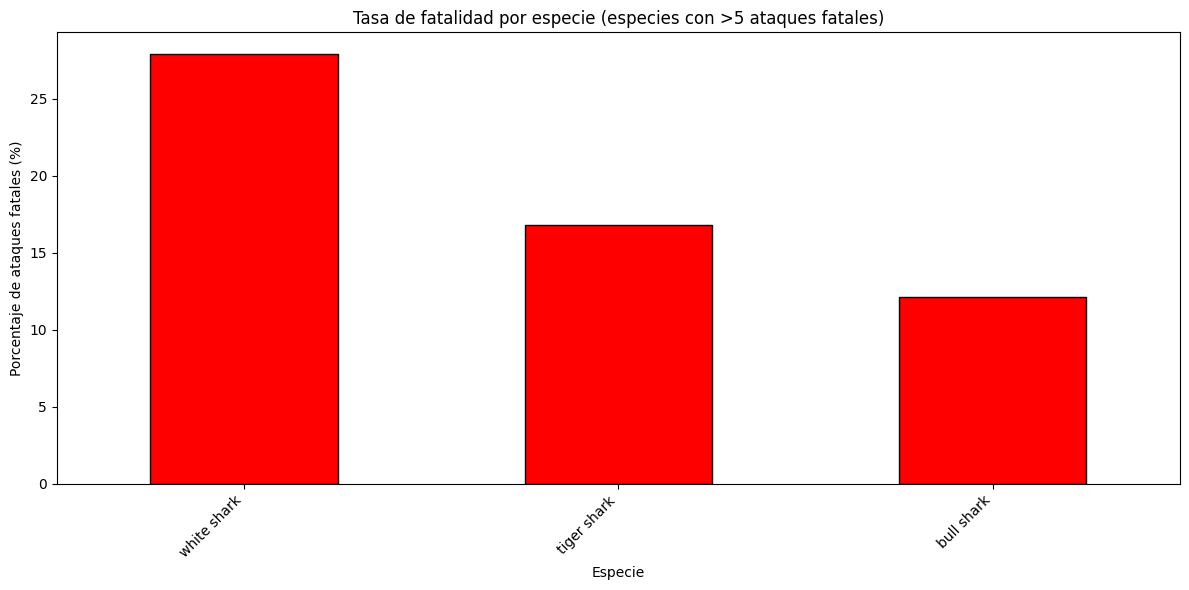

In [101]:
# Excluir unknown
shark_df_clean = shark_df[shark_df['species_clean'] != 'unknown'].copy()

# Contar ataques fatales por especie
fatal_counts = shark_df_clean.groupby('species_clean')['fatal_y/n'].apply(lambda x: (x=='y').sum())

# Seleccionar especies con más de 5 ataques fatales
species_selected = fatal_counts[fatal_counts > 5].index
shark_df_filtered = shark_df_clean[shark_df_clean['species_clean'].isin(species_selected)]

# 1. Tabla de contingencia y proporciones
cross_tab = pd.crosstab(shark_df_filtered['species_clean'], shark_df_filtered['fatal_y/n'])
cross_tab = cross_tab.sort_values(by='y', ascending=False)  # ordenar por fatalidad
print("Frecuencias absolutas (especies >5 ataques fatales):")
display(cross_tab)

cross_tab_rel = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
cross_tab_rel = cross_tab_rel.round(1)
print("Porcentaje de fatalidad por especie:")
display(cross_tab_rel)

# 2. Visualización: gráfico de barras
fatal_percentage = cross_tab_rel['y'].sort_values(ascending=False)

plt.figure(figsize=(12,6))
fatal_percentage.plot(kind='bar', color='red', edgecolor='black')
plt.ylabel("Porcentaje de ataques fatales (%)")
plt.xlabel("Especie")
plt.title("Tasa de fatalidad por especie (especies con >5 ataques fatales)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [102]:
# Bivariate - Aggregate: count attacks per species per year
bivariate_summary = (
    shark_df.groupby(['species_clean', 'year'])
    .size()
    .reset_index(name='attack_count')
)

print(bivariate_summary.head())

         species_clean  year  attack_count
0  blacktip reef shark  2001             1
1  blacktip reef shark  2006             2
2  blacktip reef shark  2013             2
3  blacktip reef shark  2014             2
4  blacktip reef shark  2015             1


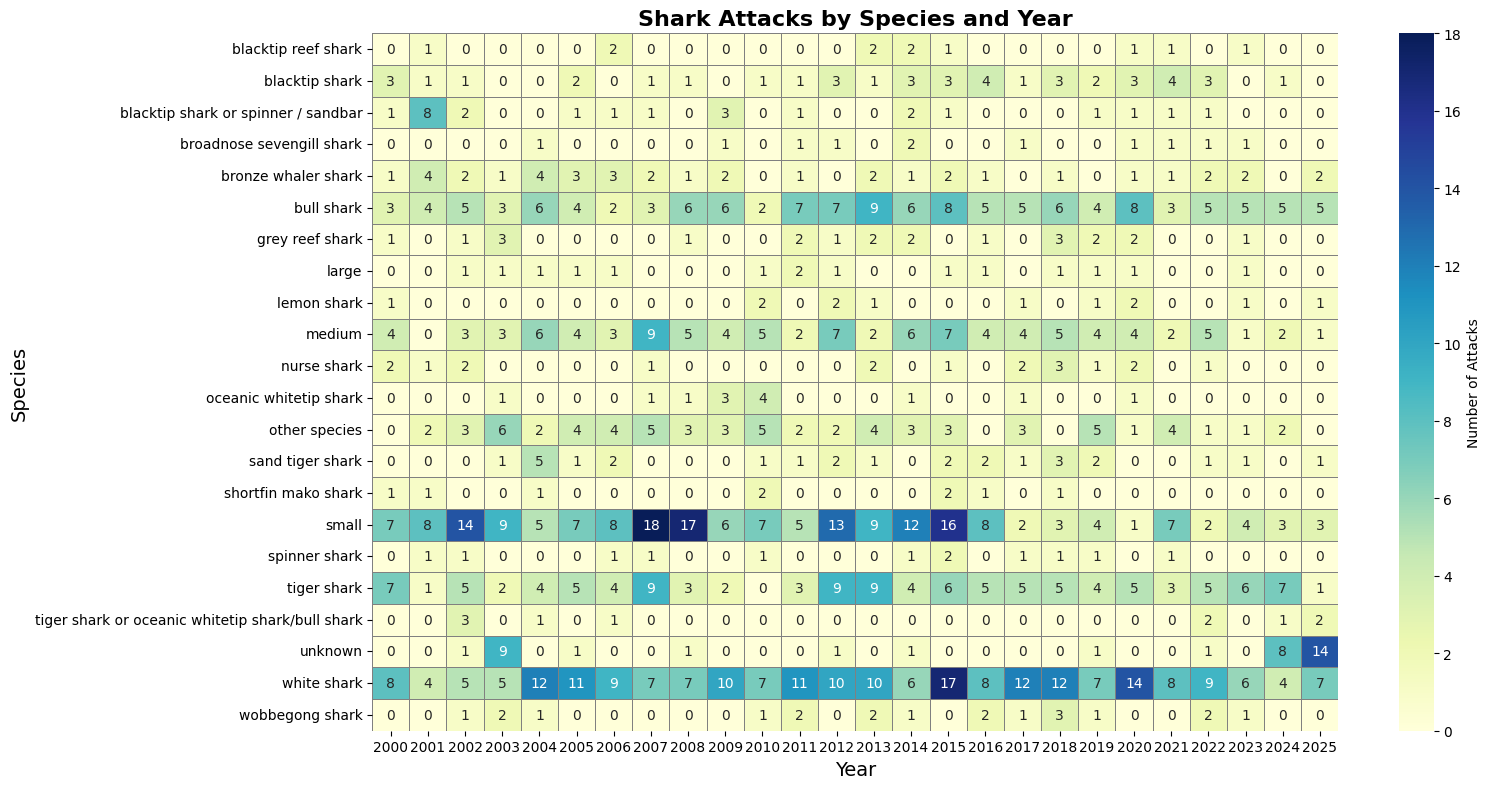

In [103]:
heatmap_data = bivariate_summary.pivot(
    index='species_clean',
    columns='year',
    values='attack_count'
).fillna(0)  # missing combinations → 0 attacks

plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_data,
    annot=True,       # show counts in cells
    fmt='g',          # general number format
    cmap='YlGnBu',    # color palette
    linewidths=.5,
    linecolor='gray',
    cbar_kws={'label': 'Number of Attacks'}
)

plt.title('Shark Attacks by Species and Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Species', fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [104]:
# Show all rows with missing Year
missing_years = shark_df[shark_df['year'].isnull()]
print(missing_years)

print(shark_df[['year', 'species_clean']].isnull().sum())

# Convert 'year' is numeric
shark_df["year"] = shark_df["year"].astype(int)
print(shark_df["year"].unique())

Empty DataFrame
Columns: [year, type, country, state, activity, sex, fatal_y/n, species, species_clean, fatal_binary]
Index: []
year               0
species_clean    752
dtype: int64
[2025 2024 2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012
 2011 2010 2009 2008 2007 2006 2005 2004 2003 2002 2001 2000]


In [105]:
# Drop rows with missing values in 'year' or 'species_clean'
shark_df_clean = shark_df.dropna(subset=["year", "species_clean"])
shark_df_clean.shape

(1169, 10)

In [106]:
!pip install plotly


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [107]:
# Análisis por YEAR - COUNTRY

year_analysis_cols = ['year', 'country', 'fatal_y/n']
dupe_mask1 = shark_df.duplicated(subset=year_analysis_cols, keep=False)
shark_df[dupe_mask1].sort_values(by=year_analysis_cols)

# Cuántas veces se repite cada combinación de las columnas clave
shark_df.groupby(year_analysis_cols).size().sort_values(ascending=False).head(10)

year  country  fatal_y/n
2015  usa      n            56
2007  usa      n            54
2012  usa      n            54
2016  usa      n            54
2014  usa      n            53
2017  usa      n            52
2013  usa      n            51
2001  usa      n            50
2019  usa      n            50
2008  usa      n            49
dtype: int64

In [108]:
# Agrupamos los datos y contamos los ataques
shark_summary = (shark_df.groupby(year_analysis_cols).size().reset_index(name="attack_count"))

shark_summary.head()

,year,country,fatal_y/n,attack_count
0,2000,australia,n,8
1,2000,australia,y,3
2,2000,new caledonia,y,1
3,2000,new zealand,n,1
4,2000,new zealand,y,1


In [109]:
import plotly.express as px

fig = px.bar(
    shark_summary,
    x="year",
    y="attack_count",
    color="fatal_y/n",
    facet_col="country",       # crea subgráficos por país
    facet_col_wrap=3,          # organiza en filas/columnas
    title="Ataques de tiburón por año y país (divido por ataque fatal/no fatal)",
    labels={
        "year": "Año",
        "attack_count": "Nº de ataques",
        "fatal_y/n": "Fatalidad"
    }
)

fig.update_layout(height=1000)
fig.show()


In [110]:
year_fatal_summary = (
    shark_summary.groupby(["year", "fatal_y/n"])["attack_count"]
    .sum()
    .reset_index()
)

fig = px.line(
    year_fatal_summary,
    x="year",
    y="attack_count",
    color="fatal_y/n",
    markers=True,
    title="Evolución de los ataques fatales vs no fatales"
)

fig.show()


In [111]:
# Análisis por COUNTRY - STATE
geo_analysis_cols = ['country', 'state', 'activity','fatal_y/n']
dupe_mask2 = shark_df.duplicated(subset=geo_analysis_cols, keep=False)
shark_df[dupe_mask2].sort_values(by=geo_analysis_cols)

# Cuántas veces se repite cada combinación de las columnas clave
shark_df.groupby(geo_analysis_cols).size().sort_values(ascending=False).head(10)

country    state              activity  fatal_y/n
usa        florida            surfing   n            293
                              swimming  n            184
australia  new south wales    surfing   n            105
usa        california         surfing   n             61
           hawaii             surfing   n             60
           south carolina     swimming  n             41
           north carolina     swimming  n             41
           florida            paddle    n             40
australia  western australia  surfing   n             38
usa        hawaii             swimming  n             32
dtype: int64

In [112]:
fig = px.density_heatmap(
    shark_summary,
    x="year",
    y="country",
    z="attack_count",
    color_continuous_scale="Cividis",
    title="Mapa de calor: dispersión de ataques por año y país"
)

fig.show()


In [113]:
geo_summary = (shark_df.groupby(['country', 'state', 'fatal_y/n']).size().reset_index(name="attack_count"))

fig = px.scatter_geo(
    geo_summary,
    locations="country",           # reconoce nombres de países automáticamente
    locationmode="country names",
    size="attack_count",
    color="fatal_y/n",
    title="Mapa interactivo de ataques de tiburón por país y estado",
    projection="natural earth"
)
fig.show()


C:\Users\marle\AppData\Local\Temp\ipykernel_4688\281653722.py:3: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



In [114]:
# Análisis por FATAL-SEX-ACTIVITY
sex_analysis_cols = ['fatal_y/n','sex', 'activity']
dupe_mask3 = shark_df.duplicated(subset=sex_analysis_cols, keep=False)
shark_df[dupe_mask3].sort_values(by=sex_analysis_cols)

# Cuántas veces se repite cada combinación de las columnas clave
shark_df.groupby(sex_analysis_cols).size().sort_values(ascending=False).head(10)

fatal_y/n  sex  activity
n          m    surfing     676
                swimming    307
           f    swimming    171
           m    fishing     140
                paddle       98
                diving       97
           f    surfing      77
y          m    surfing      43
                swimming     41
n          f    diving       40
dtype: int64

In [115]:
geo_summary = (shark_df.groupby(['country', 'activity']).size().reset_index(name="attack_count"))

fig = px.density_heatmap(
    geo_summary,
    x="activity",
    y="country",
    z="attack_count",
    color_continuous_scale="Inferno",
    title="Mapa de calor: dispersión de los ataques por actividad en cada país"
)
fig.show()


In [116]:
# Análisis por SPECIES-FATAL
species_analysis_cols = ['species','fatal_y/n']
dupe_mask4 = shark_df.duplicated(subset=species_analysis_cols, keep=False)
shark_df[dupe_mask4].sort_values(by=species_analysis_cols)

# Cuántas veces se repite cada combinación de las columnas clave
shark_df.groupby(species_analysis_cols).size().sort_values(ascending=False).head(10)

species         fatal_y/n
white shark     n            43
bull shark      n            35
4' shark        n            29
tiger shark     n            27
white shark     y            22
4' to 5' shark  n            20
6' shark        n            18
3' shark        n            17
3' to 4' shark  n            16
blacktip shark  n            15
dtype: int64

In [117]:
# Resumen species × fatal
sp_fatal = (shark_df.groupby(["species","fatal_y/n"]).size().reset_index(name="count"))

# Totales por especie
sp_total = sp_fatal.groupby("species", as_index=False)["count"].sum().rename(columns={"count":"total"})
sp_fatal = sp_fatal.merge(sp_total, on="species", how="left")

# Métricas por especie (CFR = case fatality rate)
sp_rate = (
    sp_fatal.pivot_table(index="species", columns="fatal_y/n", values="count", fill_value=0)
             .rename_axis(None, axis=1)
             .reset_index()
)
sp_rate["total"] = sp_rate.get("y",0) + sp_rate.get("n",0) + sp_rate.get("unknown",0)
sp_rate["fatality_rate"] = sp_rate.get("y",0) / sp_rate["total"]
sp_rate = sp_rate.sort_values(["total","fatality_rate"], ascending=[False, False])

# Filtro a especies con suficiente muestra para evitar ruido
MIN_N = 15
sp_fatal_top = sp_fatal[sp_fatal["total"] >= MIN_N].copy()
sp_rate_top  = sp_rate[sp_rate["total"] >= MIN_N].copy()

# Orden de categorías por volumen
species_order = sp_rate_top["species"].tolist()

In [118]:
fig = px.bar(
    sp_fatal_top.sort_values("total", ascending=False),
    x="species",
    y="count",
    color="fatal_y/n",
    title="Ataques por especie y fatalidad",
    labels={"species":"Especie","count":"Nº casos","fatal_y/n":"Fatalidad"},
    category_orders={"species": species_order}
)
fig.update_layout(
    xaxis_tickangle=45,
    barmode="stack",
    height=550
)
fig.show()


In [119]:
fig = px.scatter(
    sp_rate_top,
    x="total",
    y="fatality_rate",
    size="total",
    hover_name="species",
    title="Relación número de ataques vs tasa de fatalidad por especie",
    labels={"total":"Total casos","fatality_rate":"Tasa de fatalidad"},
    color="fatality_rate",
    color_continuous_scale="Inferno"
)
fig.update_layout(height=550, xaxis=dict(dtick=10))
fig.update_yaxes(tickformat=".0%")
fig.show()
